# Chapter 4: Functional Programming: Rudimentary Probability, Statistics, and Analytics


# Simpson's Paradox and Controlling for Gender

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import networkx as nx

In [95]:
simpsons = {j:[np.random.normal() * 20  + int(i/10) for i in range(1000)] for j in range(10)}
values = []
for j in simpsons.keys():
    ix_interval = j*100
    simpsons[j] = pd.DataFrame(simpsons[j], index = np.arange(ix_interval, len(simpsons[j]) + ix_interval)).sub(j * 35)
    simpsons[j]["Index"] = simpsons[j].index
    simpsons[j]["Entity"] = j
    values = values + list(simpsons[j].values)
stacked_simpsons = pd.DataFrame(values, columns = ["y","x", "Entity"])

Text(0.5, 1.0, 'Data appears be\n negatively correlated')

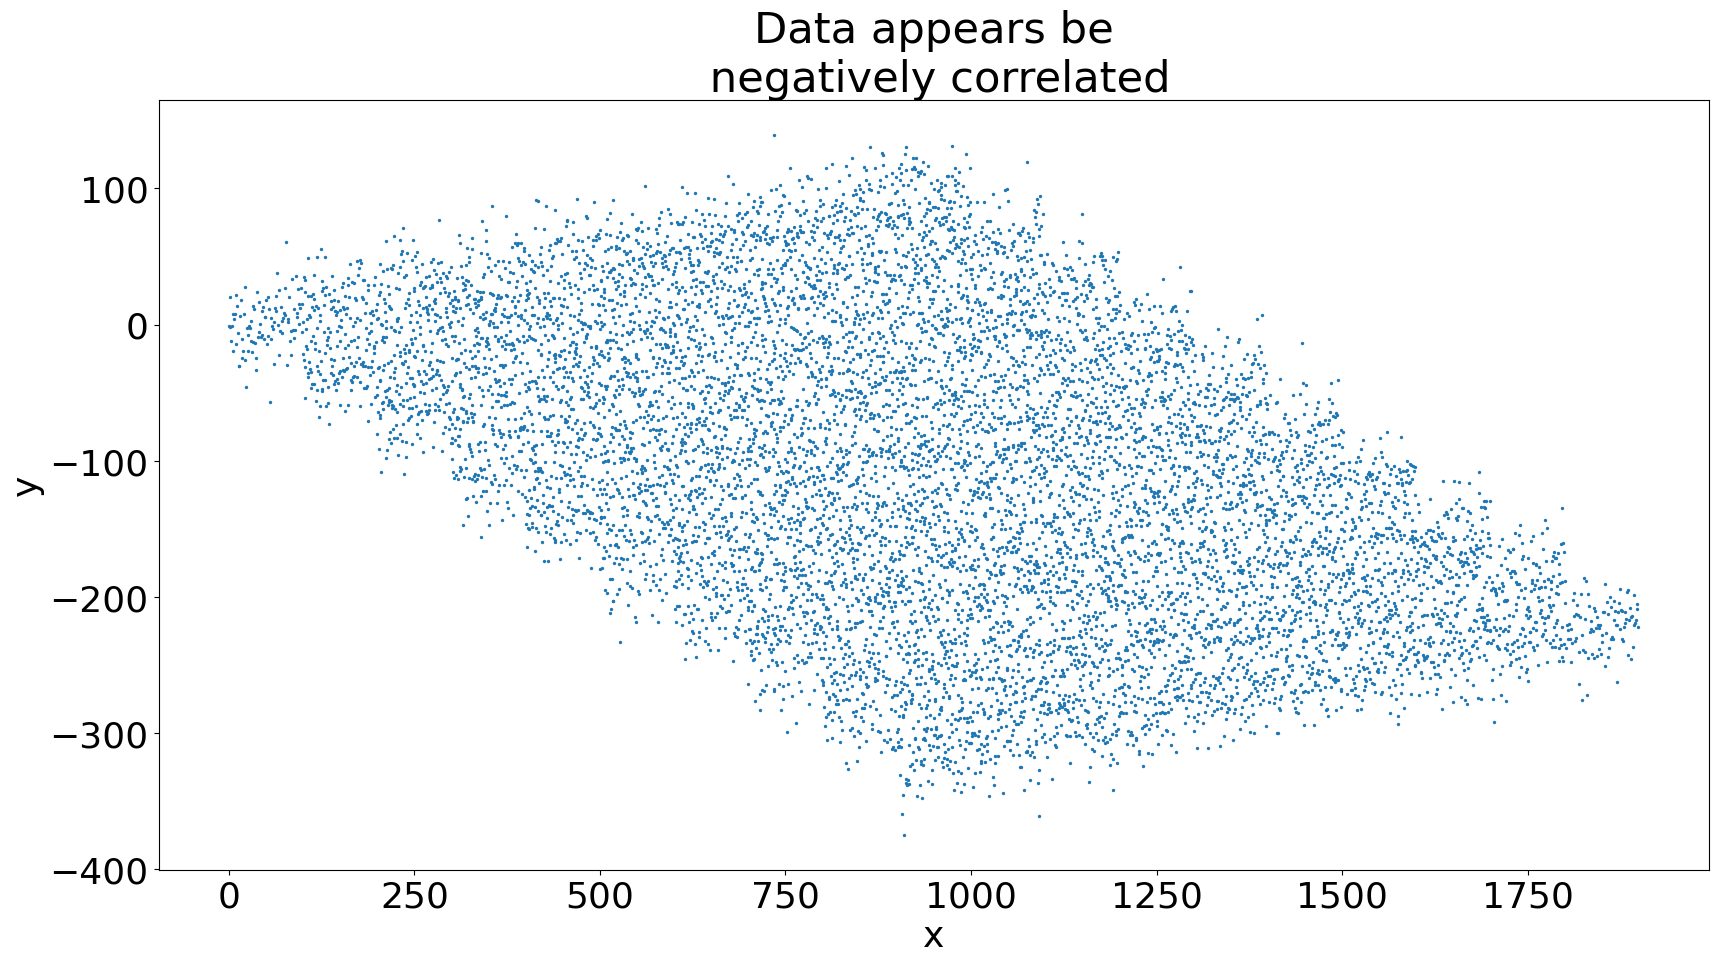

In [98]:
plt.rcParams.update({"font.size" : 26})
fig, ax = plt.subplots(figsize = (20,10))
stacked_simpsons.plot.scatter(x = "x",
                              y = "y",
                               s = 2, 
                               ax = ax,
                               c= "C0")
ax.set_title("Data appears be\n negatively correlated")

Text(0.5, 1.0, 'With Group Controls\nCorrelations is Positive')

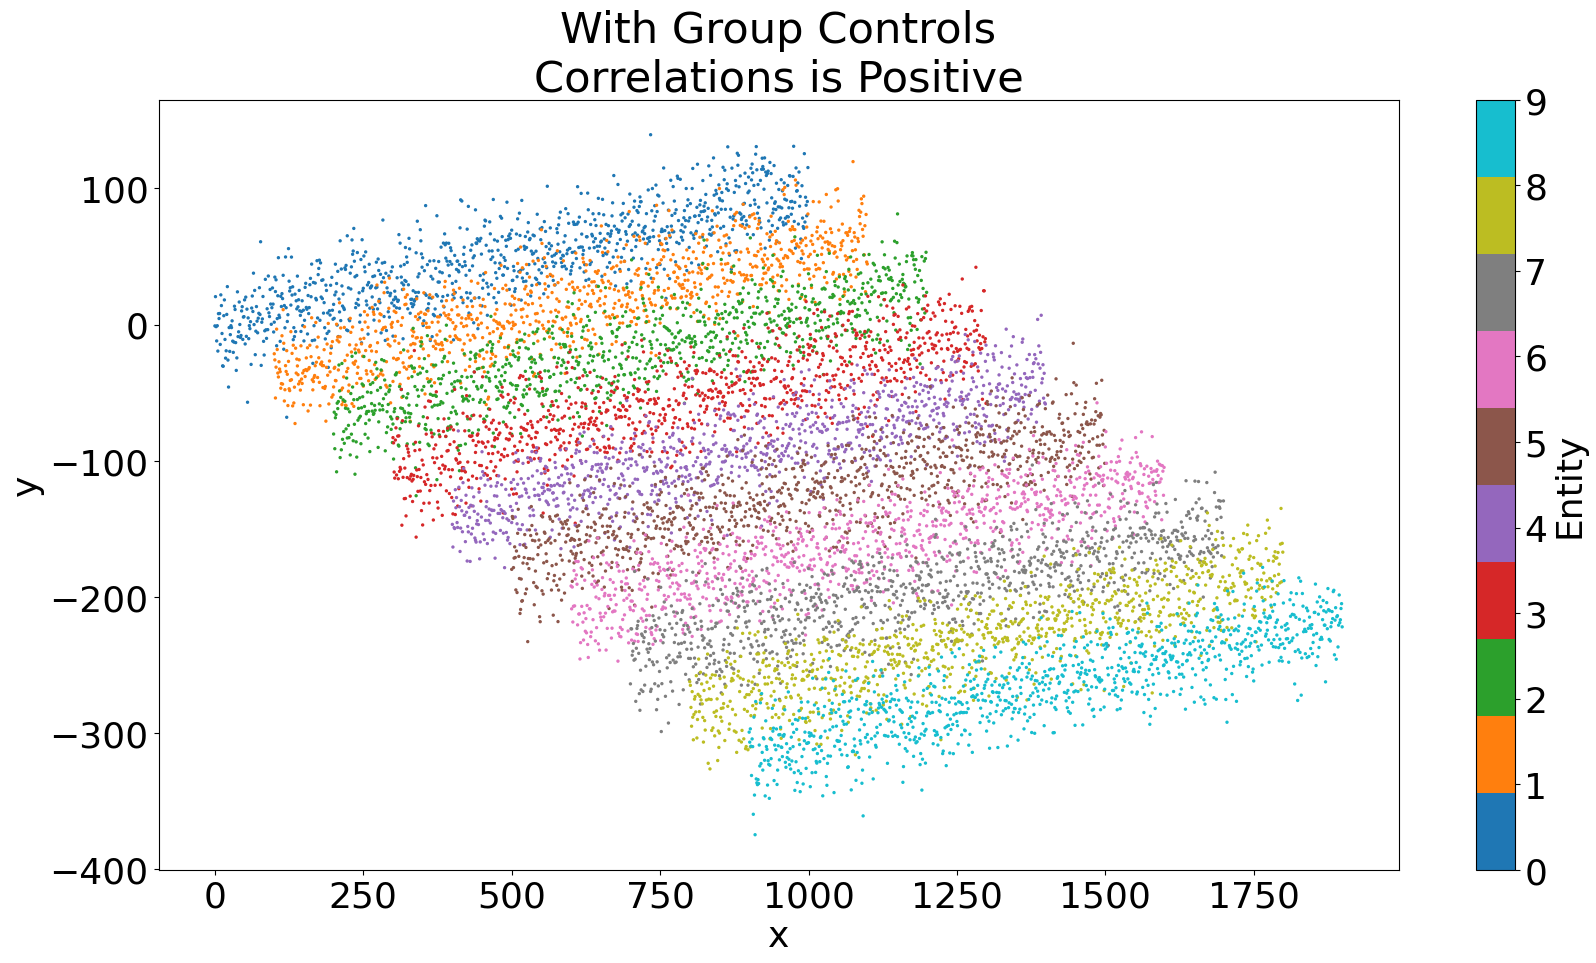

In [99]:
fig, ax = plt.subplots(figsize = (20,10))
stacked_simpsons.plot.scatter(x = "x",
                              y = "y",
                               s = 2, 
                               ax = ax,
                              cmap = "tab10",
                               c= "Entity")
ax.set_title("With Group Controls\nCorrelations is Positive")

#### Data from *Causal Inference and Discovery in Python*.

In [100]:
data = pd.read_csv("https://raw.githubusercontent.com/PacktPublishing/Causal-Inference-and-Discovery-in-Python/main/data/ch_01_drug_data.csv").set_index("Drug").T.reset_index()
for ab in ("A","B"):
    data["index"][data["index"] == ab + ".1"] = ab
data.rename(columns={"index":"Drug"}, inplace = True)
data

C:\Users\JLCat\AppData\Local\Temp\ipykernel_22008\2929714734.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Drug Drug  Clot  Female  Male  Total
0       A     1      24     3     27
1       A     0      56    39     95
2       B     1      17     6     23
3       B     0      25    74     99

In [101]:
plot_df = data.groupby(["Drug","Clot"])["Total"].sum().unstack()
plot_df

Clot   0   1
Drug        
A     95  27
B     99  23

### Stacked Barplot (Matplotlib)

<AxesSubplot:xlabel='Drug'>

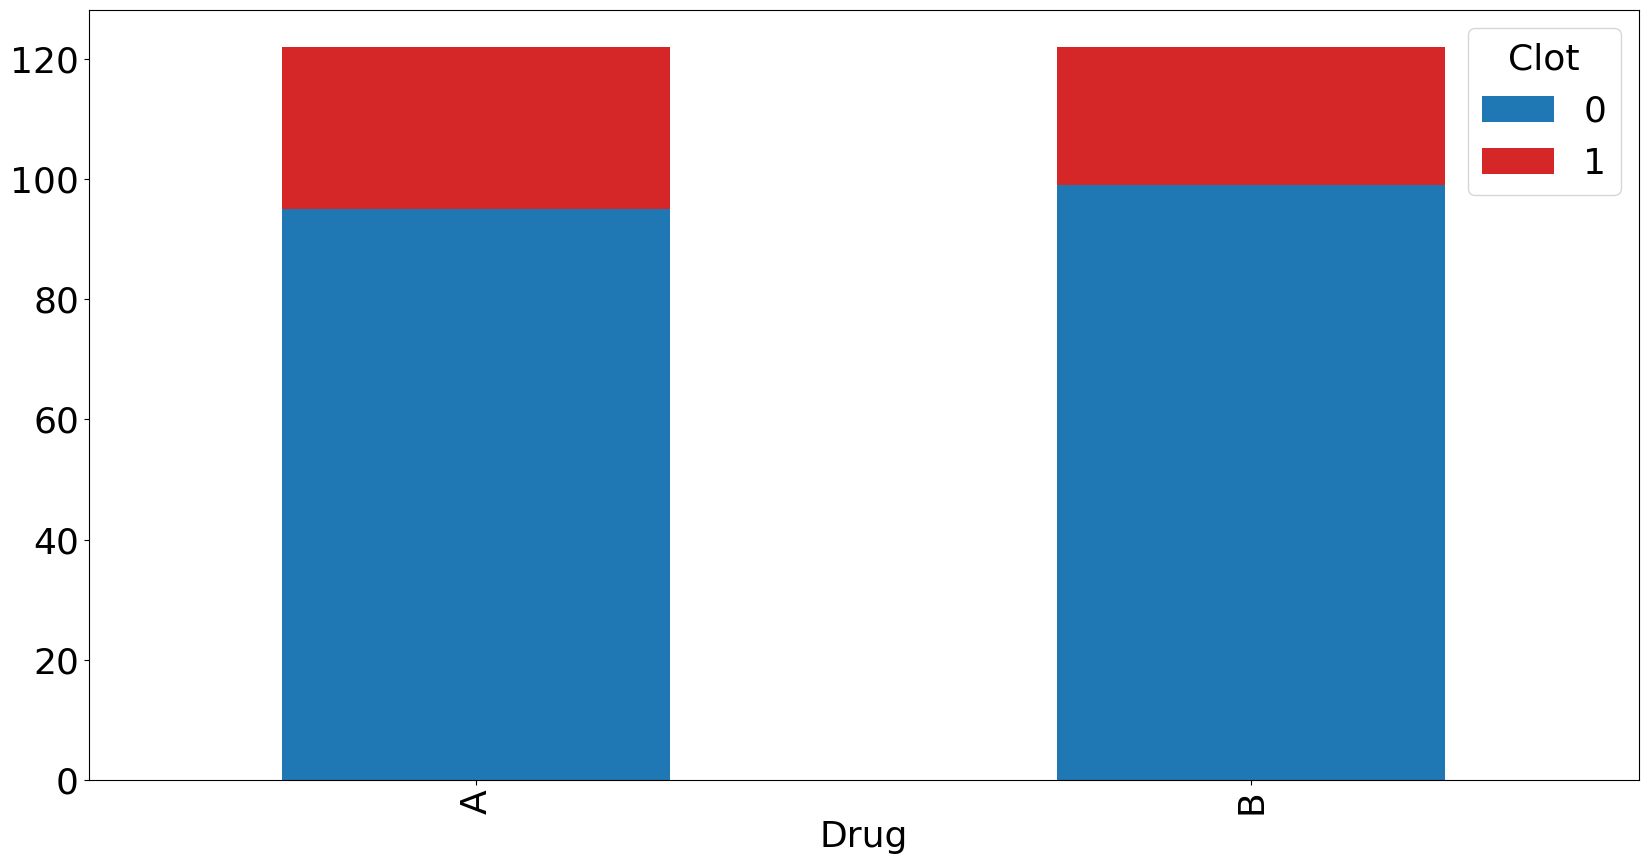

In [102]:
colors = ["C0","C3"]
fig, ax = plt.subplots(figsize = (20,10))
plot_df.plot.bar(ax = ax, stacked = True, legend = True, color = colors)

### Stacked Barplot (Plotly)

In [103]:
import plotly.graph_objects as go
fig = go.Figure()

# Adding each stack (clot type in this case) as a separate trace
for clot_type in plot_df.columns:
    fig.add_trace(go.Bar(
        x=plot_df.index,
        y=plot_df[clot_type],
        name="Clot: " + str(clot_type)
    ))

# Update layout for a stacked bar plot
fig.update_layout(
    barmode='stack',
    title='Clotting by Drug',
    xaxis_title='Drug',
    yaxis_title='Total'#,
#     legend_title='Clot Type'
)

# Show the plot
fig.show()

It appears that Drug B is more effective than Drug A at preventing blood clots. However, we have not controlled for a highly relevant factor: gender. If we differentiate the sample for each drug trial by gender, we see that the sample for drug A is biased toward females sample for drug B is biased toward males. If we don't account for this gender bias, we would incorrectly infer that drug B is more effective at preventing blood clots.

In [104]:
plot_df = data.groupby(["Drug","Clot"])["Male", "Female"].sum().unstack().T
plot_df.index.names = ("Gender","Clot")
plot_df = plot_df.groupby("Gender").sum().T
plot_df

C:\Users\JLCat\AppData\Local\Temp\ipykernel_22008\511028341.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



Gender  Male  Female
Drug                
A         42      80
B         80      42

### Stacked Barplot (Matplotlib)

<AxesSubplot:xlabel='Drug'>

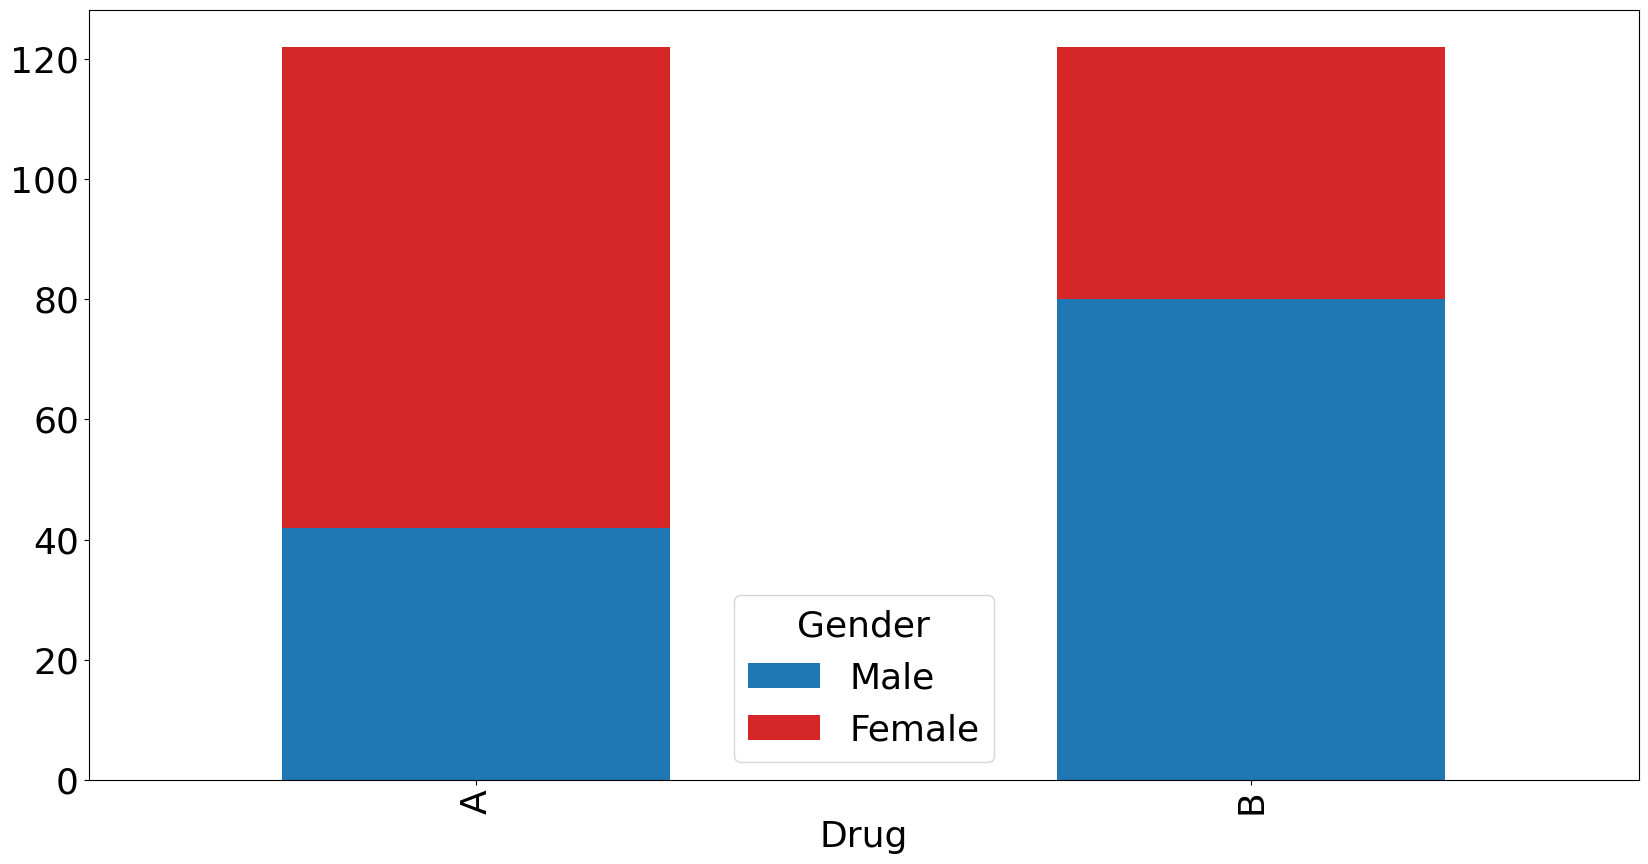

In [105]:
fig, ax = plt.subplots(figsize = (20,10))
plot_df.plot.bar(ax = ax, stacked =True, color = colors, legend = True)


In [106]:
plot_df = data.groupby(["Drug","Clot"])["Male", "Female"].sum().unstack().T
plot_df.index.names = ("Gender", "Clot")
plot_df = plot_df.groupby("Gender").sum().T

# Create an interactive stacked bar plot using Plotly
fig = go.Figure()

# Adding each stack (gender in this case) as a separate trace
for gender in plot_df.columns:
    fig.add_trace(go.Bar(
        x=plot_df.index,
        y=plot_df[gender],
        name=str(gender)
    ))

# Update layout for a stacked bar plot
fig.update_layout(
    barmode='stack',
    title='Gender Composition by Drug Trial',
    xaxis_title='Drug',
    yaxis_title='Total Count',
    legend_title='Gender'
)

# Show the plot
fig.show()

C:\Users\JLCat\AppData\Local\Temp\ipykernel_22008\106628809.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [107]:
plot_df = data.groupby(["Clot","Drug"])["Male","Female","Total"].sum().unstack().T
pct_df = plot_df.copy()
for key in pct_df.keys():
    print(key)
    pct_df[key] = pct_df[key].div(plot_df.sum(axis = 1))
pct_df


0
1


C:\Users\JLCat\AppData\Local\Temp\ipykernel_22008\1425366878.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



Clot                0         1
Drug   Drug                    
Male   A     0.928571  0.071429
       B     0.925000  0.075000
Female A     0.700000  0.300000
       B     0.595238  0.404762
Total  A     0.778689  0.221311
       B     0.811475  0.188525

### Stacked Barplot (Matplotlib)

<AxesSubplot:xlabel='Drug,Drug'>

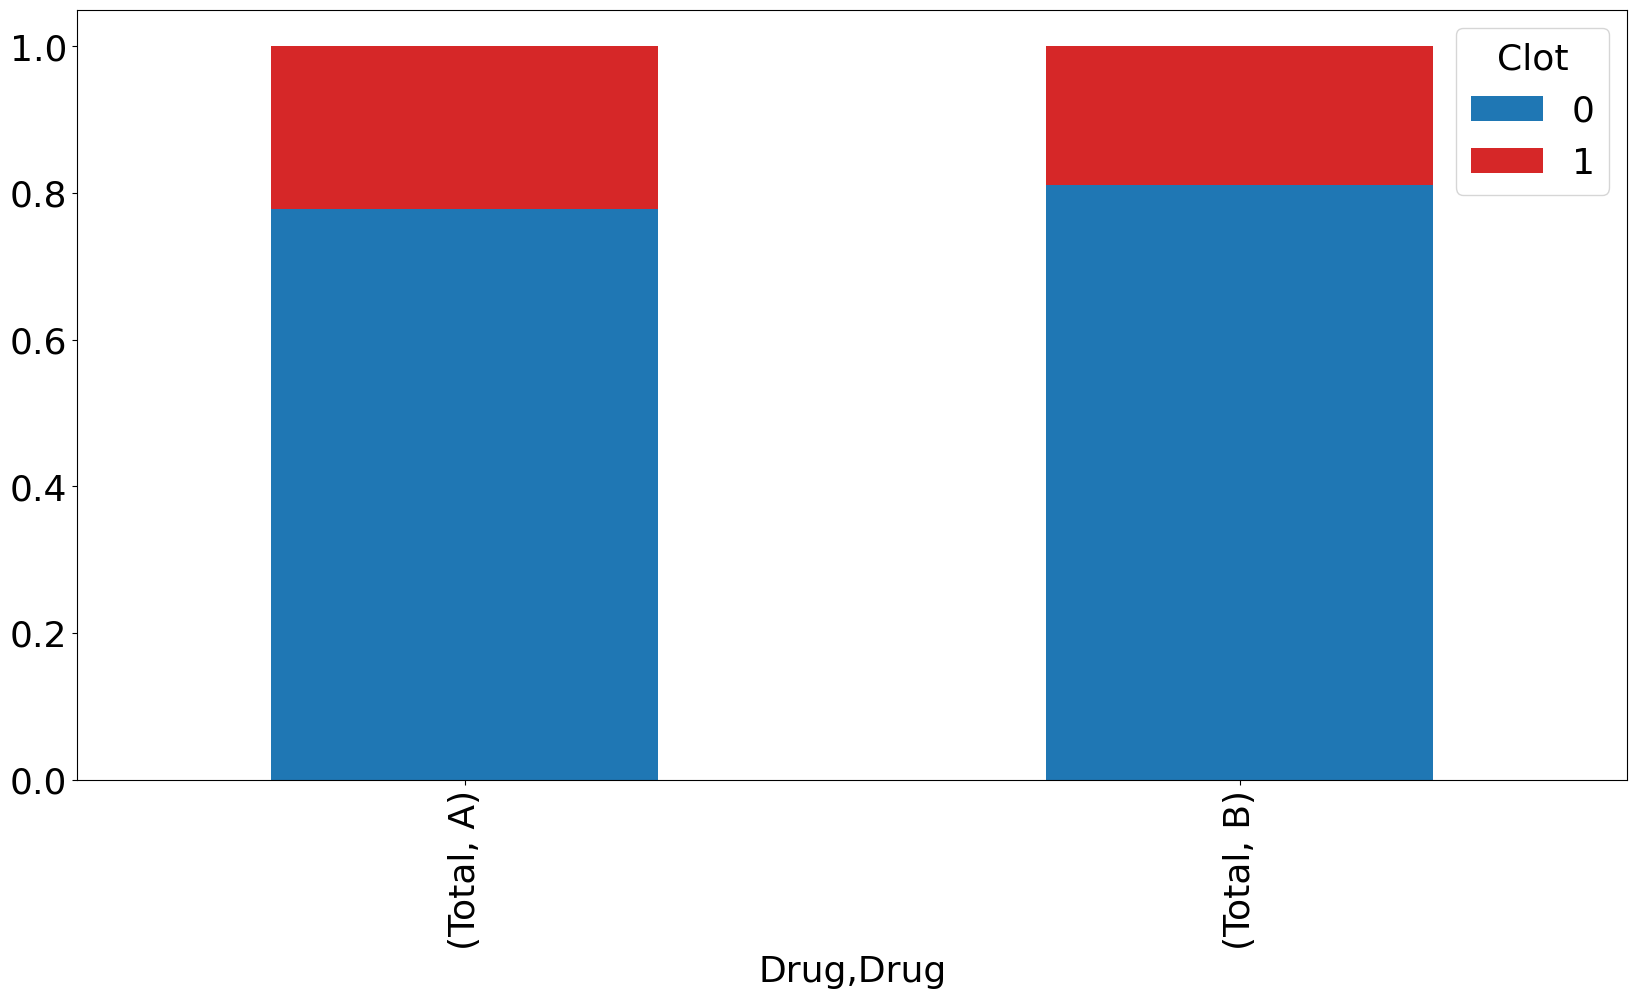

In [108]:
fig, ax = plt.subplots(figsize = (20,10))
pct_df.loc[["Total"]].plot.bar(ax = ax, stacked = ["Clot"],
                               color = colors, 
                               legend = True)

### Stacked Barplot (Plotly)

In [109]:
# Creating the plot_df as per your provided code
plot_df = data.groupby(
    ["Clot", "Drug"])["Male", "Female", "Total"].sum().unstack().T
pct_df = plot_df.copy()

# Calculating the percentage
for key in pct_df.keys():
    pct_df[key] = pct_df[key].div(plot_df.sum(axis=1))

# Filtering for the 'Total' row
pct_df_total = pct_df.loc[["Total"]]

# Create an interactive stacked bar plot using Plotly
fig = go.Figure()

# Adding each stack (clot type in this case) as a separate trace
for clot_type in pct_df_total.columns:
    fig.add_trace(go.Bar(
        x=pct_df_total.index.get_level_values(1),  # Drug names
        y=pct_df_total[clot_type],
        name="Clot: " + str(clot_type)
    ))

# Update layout for a stacked bar plot
fig.update_layout(
    barmode='stack',
    title='Clotting by Drug',
    xaxis_title='Drug',
    yaxis_title='Percentage'#,
#     legend_title='Clot Type'
)

# Show the plot
fig.show()

C:\Users\JLCat\AppData\Local\Temp\ipykernel_22008\2158136995.py:2: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



By accounting for gender, we find that 1) males who take either drug tend to have fewer blood clots than comparable females and 2) drug A is more effective for preventing clots in females than drug B.

### Stacked Barplot (Matplotlib)

<AxesSubplot:xlabel='Drug,Drug'>

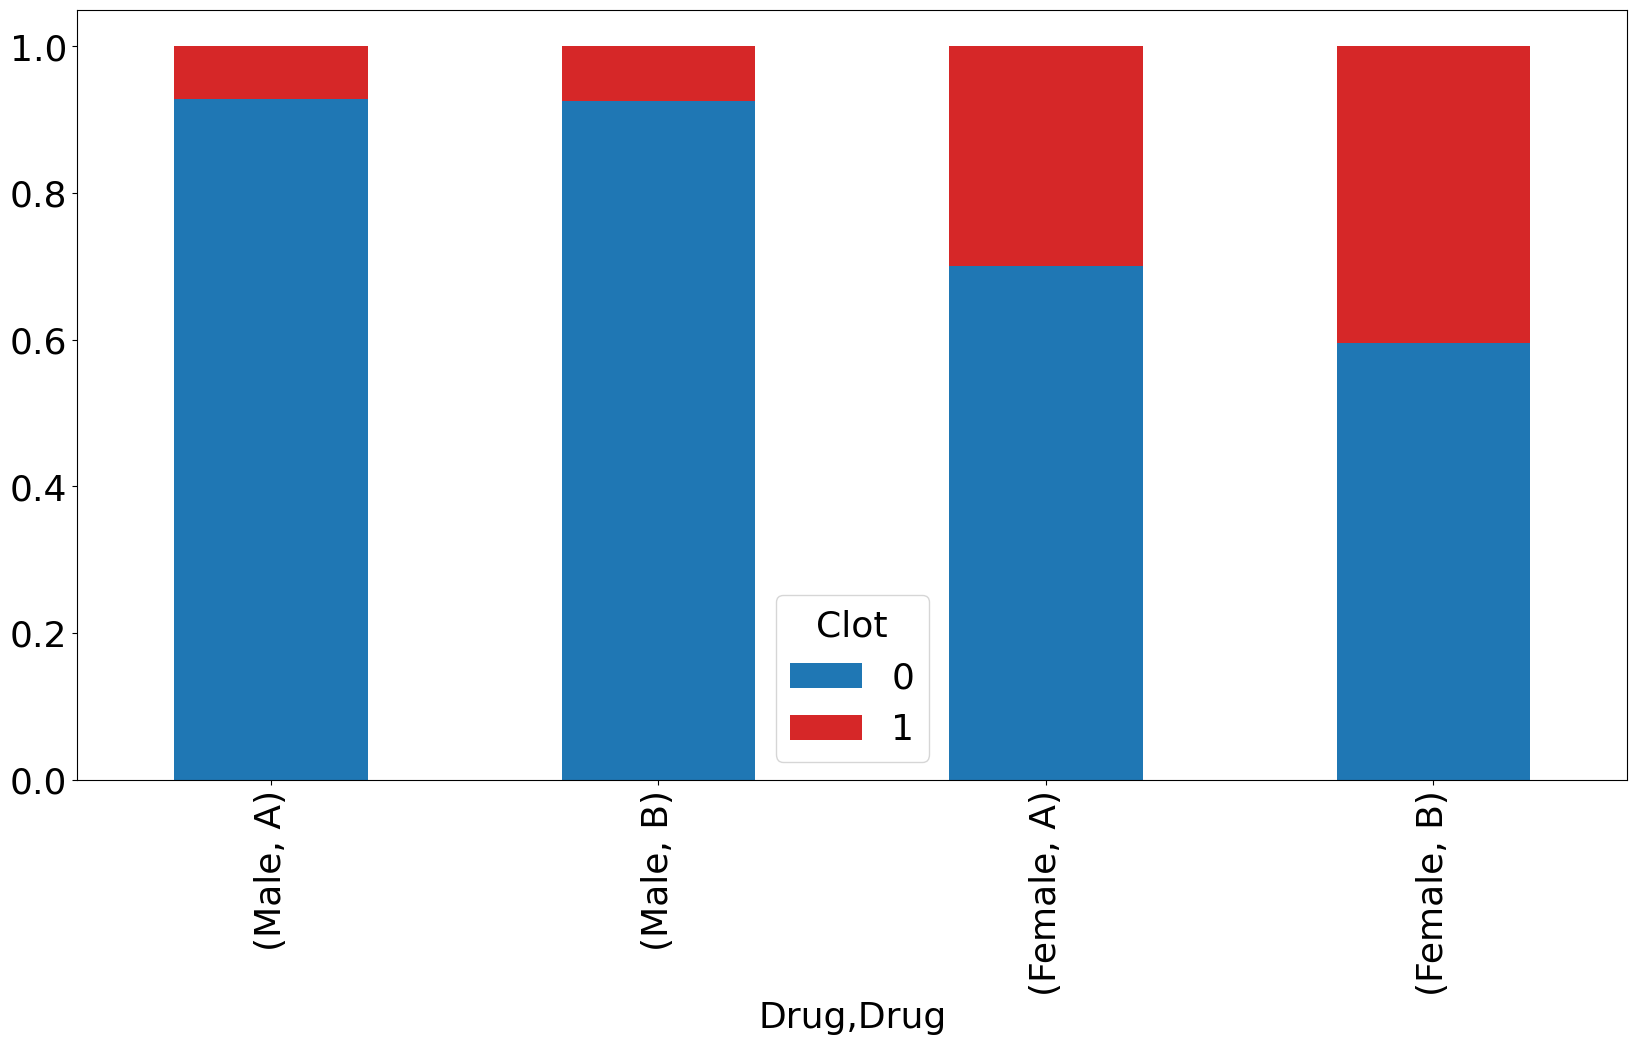

In [110]:
fig, ax = plt.subplots(figsize = (20,10))
pct_df.loc[["Male","Female"]].plot.bar(
    ax = ax,
    stacked = ["Clot"],
    color = colors,
    legend = True)

In [111]:
pct_df_gender = pct_df.loc[["Male", "Female"]].round(3)
color_map = {
    0: 'blue',  # Color for Clot 0
    1: 'red'    # Color for Clot 1
}

# Transparency (alpha) values for gender
opacity_map = {
    'Male': 1,    # Opaque for males
    'Female': 0.6  # More transparent for females
}

# Initialize an empty figure
fig = go.Figure()

# Iterate through the DataFrame and add a bar for each gender and drug combination
for (gender, drug), values in pct_df_gender.iterrows():
    for clot in range(len(values)):
        fig.add_trace(go.Bar(
            name=f"Clot {clot}",  # We will use this in the legend
            x=[f"{gender} {drug}"],
            y=[values[clot]],
            marker=dict(color=color_map[clot], opacity=opacity_map[gender]),
            legendgroup=f"Clot {clot}",
            showlegend=False  # We do not show these traces in the legend
        ))

# Add two traces for the legend
for clot in [0, 1]:
    fig.add_trace(go.Bar(
        name=f"Clot {clot}",
        x=[None],
        y=[None],
        marker=dict(color=color_map[clot], opacity=1),
        legendgroup=f"Clot: {clot}",
        showlegend=True
    ))

# Update layout for stacked bar plot
fig.update_layout(
    barmode='stack',
    title='Clots by Gender and Durg',
    xaxis=dict(title='Drug', type='category'),
    yaxis=dict(title='Percentage'),
    legend_title='Clot',
    legend=dict(
        traceorder='normal',
        orientation='h',
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

# Show the plot
fig.show()




Often we are performing statistical operations over a large dataset. It can be difficult to understand the meaning conveyed by these measures. Learning to program presents an opportunity to better understand how functions work. In this chapter we will create some basic statistical functions and compare their output to the functions built into python. By creating the function, you will understand the meaning of summation signs. Computing these statistics by hand would be a laborious process and expensive in terms of time. Once a function is constructed, it can be employed to calculate statistics in a fraction of the time.

## Building a Function

| New Concepts | Description |
| --- | --- |
| _return obj_ (from function) | Functions may return an object to be saved if a variable is defined by the function i.e., var1 = function(obj1, obj2, . . .)|

So far, we have built programs on the fly. For purposes of pedagogy, this is fine. As you develop your skills, you want to form good practices. This includes the building of functions for repeated use as well as the building of classes. This chapter we will concentrate on functions. Build all of your functions in the same file, _statsFunctions.py_.

In python, functions take the form:

In [ ]:
def function_name(object1, object2, . . ., objectn):
    <operations>

If the function allows, you will pass an object by calling it in the parentheses that follow the function name. The first function that we build will be the total() function. We define the function algebraically as the sum of all values in a list of length j:

$\sum_{i=0}^{n-1} x_{i}$

Since lists indices start with the integer 0, we will write our functions as starting with _i = 0_ and process elements to the index of value _n - 1_. Since the range function in Python automatically counts to one less than the value identified, the for-loop used will take the form:

In [18]:
n=0
i=0
for values in range(i+1):
    i += 1

We will use it to return the sum of values in a list. After building this, we will pass a list to the function:

In [19]:
#statsFunctions.py
import random

def total(lst):
    total_ = 0
    n = len(lst)
    for i in range(n):
        total_ += lst[i]
    return total_

X1 = [3, 6, 9, 12, 15,18,21,24,27,30]
X2 = [random.randint(0,100) for i in range(10)]
print("X1:", X1)
print("X2:", X2)


X1: [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
X2: [0, 44, 68, 90, 46, 100, 57, 5, 85, 22]


In [20]:
total1 = total(X1)
total2 = total(X2)
print("total of list1:", total1)
print("total of list2:", total2)

total of list1: 165
total of list2: 517


The total() function is a simple function that will be used in many of the other functions that we write. You can find this and other functions from this chapter in [statsFunctions.py](https://github.com/jlcatonjr/Learn-Python-for-Stats-and-Econ/tree/master/Chapter%203).

## Statistical Functions
| New Concepts | Description |
| --- | --- |
| Operators e.g., !=, %, +=, \*\* | The operator != tests whether the values on either side of the operator are equal; _a % b_ returns the remainder of $a / b$; _a += b_ sets a equal to $a + b$; _a ** b_ raises a to the b power ($a^b$). |
| Dictionary | A dictionary is a datastructure that uses keys instead of index values. Each unique key references an object linked to that key. |
| Dictionary Methods e.g., _dct.values()_ | dct.values() returns a list of the objects that are referenced by the dictionaries keys.|
| Default Function Values | Function may assume a default value for values passed to it. e.g., _def function(val1 = 0, val2 = 2, …)_ | 

### Average Statistics

#### Mean


Let $X_1, X_2,...,X_n$ represent $n$ random variables. For a given dataset, useful descriptive statistics of central tendency include mean, median, and mode, which we built as functions in a previous chapter. 

We define the mean of a set of numbers:
$\bar{X} = \frac{\sum_{i=0}^{n-1} x_{i}} {n}$

The **mean** gives the expected value - often denoted $E(X)$ or $\bar{X}$- from a series, $X$, by summing all of the observations and dividing by the number of them. The series may be a sample or may include the full population of interest, in which we would identify the mean by the symbol, $\mu_x$. 

The top part of the function is the same as the notation that represents the sum of a list of numbers. Thus, in mean(), we call total() and divide the result by the length of the list.  Then, we use the function to calculate value and save that value as an object:

In [21]:
#statsFunctions.py
#. . . 
def mean(lst):
    n = len(lst)
    mean_ = total(lst) / n
    return mean_

# . . . 
mean1 = mean(X1)
mean2 = mean(X2)
print("mean of X1:", mean1)
print("mean of X2:", mean2)

mean of X1: 16.5
mean of X2: 51.7


We should not be surprised that the mean of our list $X_2$ is close to the value 50.

If $\mu_X$ is unknown(which is more common), and we have only a _sample_ of data drawn randomly from a population, we use $\bar{X}$ as an _estimator_ of $\mu$. One must keep in mind that each sample mean $\bar{X_i}$ drawn from the same population is likely to vary; consequently, some degree of uncertainty is involved with $\bar{X}$.

Now that we have set up total and mean functions, we are ready to calculate 
other core statistical values: 

1. median
2. mode
3. variance
4. standard deviation
5. standard error
6. covariance
7. correlation

Statistical values provide information about the shape and structure of data. These values are aggregates as they sum some characteristic from the dataset, and transform it to a value representative of the whole dataset. Above, we have  already calculated the mean, now we shall calculate the other average values, median and mode. 

#### Median

The **median** is defined is the middle most number in a list. It is less sensitive to outliers than mean; it is the value in the middle of the dataset. For a series of *odd length* defined by a range [i, n] starting with index $i=0$, the median is $\frac{n}{2}$. 

For a series that is of *even length* but otherwise the same, the median is the mean value of the two values that comprise middle of the list. The indices of these numbers are equal defined: 

$$i_1 = \frac{n + 1}{2}; i_2\frac{n - 1}{2}$$

The median is thus defined:
$$\frac{x_\frac{n + 1}{2}+x_\frac{n-1}{2}}{2}$$

We can restate that:

$$k = x_\frac{n + 1}{2}+x_\frac{n-1}{2}$$

Thus, the median is defined as $\frac{k}{2}$.


In [22]:
#statsFunctions.py 
#. . .
def median(lst):
    n = len(lst)
    lst = sorted(lst)
    #lists of even length divided by 2 have reminder 0
    if n % 2 != 0:
        #list length is odd
        middle_index = int((n - 1) / 2)
        median_ = lst[middle_index]
    else:
        upper_middle_index = int(n / 2)
        lower_middle_index = upper_middle_index - 1
        # pass slice with two middle values to mean()
        median_ = mean(lst[lower_middle_index : upper_middle_index + 1])
        
    return median_
# . . . 
median1 = median(X1)
median2 = median(X2)
print("median of X1:", median1)
print("median of X2:", median2)

median of X1: 16.5
median of X2: 51.5


#### Mode

The mode of a list is defined as the number that appears the most in series of values. 

In order to quickly and cleanly identify the mode, we are going to use a new data structure: the dictionary. The dictionary is like a list, but elements are called by a key, not by elements from an ordered set of index numbers. We are going to use the values from the list passed to the function as keys. Every time a value is passed, the dictionary will indicate that it has appeared an additional time by adding one to the value pointed to by the key. We will pass the lists that we used in the previous exercises:

In [23]:
#statsFunctions.py
# . . .
def mode(lst):
    # use to record value(s) that appear most times
    max_count = 0
    # use to count occurrences of each value in list
    counter_dict = {}
    for value in lst:
        # count for each value should start at 0
        counter_dict[value] = 0
    for value in lst:
        # add on to the count of the value for each occurrence in lst
        counter_dict[value] += 1
    # make a list of the value (not keys) from the dictionary
    count_list = list(counter_dict.values())
    # and find the max value
    max_count = max(count_list)
    # use a generator to make a list of the values (keys) whose number of 
    # occurences in the list match max_count
    mode_ = [key for key in counter_dict if counter_dict[key] == max_count]
    
    return mode_

# . . .
mode1 = mode(X1)
mode2 = mode(X2)
print("mode of list1:", mode1)
print("mode of list2:", mode2)

mode of list1: [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
mode of list2: [0, 44, 68, 90, 46, 100, 57, 5, 85, 22]


Note that instead of using the command for _i in range(n)_, the command for value in lst is used. The first command counts from 0 to *j* using *i* and can be used to call elements in the list of interest by passing *i* in the form *lst[i]*. In the cases above, we called the values directly, passing them to *counter_dict* to count the number of times each value appears in a list, first initializing the dictionary by setting to 0 the value linked to each key. Then we add 1 for each time that a value appears. We identify that maximum number of times a value appears by taking the maximum value in *count_list*, which is simply a list of the values held by *counter_dict*. Once the *count_list* is created, identify the maximum value of the list and collect keys that point to that value in *counter_dict* by comparing each the value linked to each key to the *max_count*.

### Statistics Describing Distributions

#### Variance

Average values do not provide a robust description of the data. An average does not tell us the shape of a distribution. In this section, we will build functions to calculate statistics describing distribution of variables and their relationships. The first of these is the variance of a list of numbers.

We define population variance as:

$$ \sigma^2 = \frac{\sum_{i=1}^n (X_i - \bar{X})^2}{n}$$

When we are dealing with a sample, which is a subset of a population of observations, then we divide by $n - 1$, the **Degrees of Freedom**, to unbias the calculation. 

$$DoF = n - 1$$

The degrees of freedom is the number of independent observation that go into the estimate of a parameter (sample size $n$), minus the number of parameters used as intermediate steps in the estimation of the parameter itself. So if we estimate $\bar{x}$ once, we estimate value of X using a single parameters. (We will see that we use multiple values to estimate X when we use Ordinarly Least Squares Regression.): 


$$ S^2 = \frac{\sum_{i=1}^n (X_i - \bar{X})^2}{n-1}$$

Next, we build functions that calculate a population's variance and standard deviation. We will include an option for calculating sample variance and sample standard deviation.

In [24]:
def variance(lst, sample = True):
    # popvar(list) = sum((xi - list_mean)**2) / n for all xi in list
    # save mean value of list
    list_mean = mean(lst)
    # use n to calculate average of sum squared diffs
    n = len(lst)
    DoF = n - 1
    # create value we can add squared diffs to
    sum_sq_diff = 0
    for val in lst:
        # adds each squared diff to sum_sq_diff
        sum_sq_diff += (val - list_mean) ** 2
    if sample == False:
        # normalize result by dividing by n
        variance_ = sum_sq_diff / n
    else:
        # for samples, normalize by dividing by (n-1)
        variance_ = sum_sq_diff / DoF
    
    return variance_

# . . . 
variance1 = variance(X1, sample = False)
variance2 = variance(X2, sample = False)
print("variance X1:", variance1)
print("variance X2:", variance2)

variance X1: 74.25
variance X2: 1103.0099999999998


We call sample variance by passing a $True$ to the sample parameter. We will presume that the sample parameter is $True$ throughout the remainder of this chapter.

In [25]:
sample_variance1 = variance(X1)
sample_variance2 = variance(X2)
print("sample variance of X1", sample_variance1)
print("sample variance of X2", sample_variance2)

sample variance of X1 82.5
sample variance of X2 1225.5666666666666


#### Standard Deviation

From a list’s variance, we calculate its standard deviation as the square root of the variance. Standard deviation is regularly used in data analysis, primarily because it has the same units of measurement as the mean. It corrects the squaring of individual observations deviations from the mean done when calculating variance. It is denoted $s$ when working with a sample with an unknown population mean $\mu$. $s$ is an _estimator_ of $\sigma$, which is standard deviation when $\mu$ is known: 

$s = \sqrt{S^2}$

This is true for both the population and sample standard deviations. The function and its employment are listed below:

In [26]:
#statsFunctions.py
# . . .
def SD(lst, sample = True):
    # Standard deviation is the square root of variance
    SD_ = variance(lst, sample) ** (1/2)
    
    return SD_

# . . . 
SD1 = SD(X1)
SD2 = SD(X2)
print("SD of X1:", SD1)
print("SD of X2:", SD2)

SD of X1: 9.082951062292475
SD of X2: 35.00809430212771


#### Standard Error

Next, we will calculate the **standard error** of the sample mean. This describes how likely a given random sample mean $\bar{x_i}$ is to deviate from the population mean $\mu$. It is the standard deviation of the probability distribution for the random variable $\bar{X}$, which represents all possible samples of a single given sample size $n$. As $n$ increases, $\bar{X}$ can be expected to deviate less from $\mu$, so standard error decreases. Because population standard deviation $\sigma$ is rarely given, we again use an _estimator_ for standard error, denoted $s_\bar{x}$. Populational data has no standard error as $\mu$ can only take on a single value. 

In [27]:
def STE(lst, sample = True):
    n = len(lst)
    se = SD(lst, sample) / n ** (1/2)
    
    return se

In [28]:
print(STE(X1, sample = True))
print(STE(X2))

2.872281323269014
11.070531453668638


We have left to build function for covariance and, correlation, skewness and kurtosis. Covariance measures the average relationship between two variables. Correlation normalizes the covariance statistic a fraction between 0 and 1.

To calculate covariance, we multiply the sum of the product of the difference between the observed value and the mean of each list for value _i = 1_ through _n = number of observations_:

$cov_{pop}(x,y) = \frac{\sum_{i=0}^{n-1} (x_{i} - x_{mean})(y_{i} - y_{mean})} {n}$

We pass two lists through the covariance() function. As with the _variance()_ and _SD()_ functions, we can take the sample-covariance.

$cov_{sample}(x,y) = \frac{\sum_{i=0}^{n-1} (x_{i} - x_{mean})(y_{i} - y_{mean})} {n - 1}$

In order for covariance to be calculated, it is required that the lists passed to the function are of equal length. So we check this condition with an if statment:

In [29]:
#statsFunctions.py

def covariance(lst1, lst2, sample = False):
    # determine the mean of each list
    mean1 = mean(lst1)
    mean2 = mean(lst2)
    # instantiate a variable holding the value of 0; this will be used to 
    # sum the values generated in the for loop below
    cov = 0
    n1 = len(lst1)
    n2 = len(lst2)
    # check list lengths are equal
    if n1 == n2:
        n = n1
        # sum the product of the differences
        for i in range(n):
            cov += (lst1[i] - mean1) * (lst2[i] - mean2)
        if sample == False:
            cov = cov / n
        # account for sample by dividing by one less than number of elements in list
        else:
            cov = cov / (n - 1)
        # return covariance
        return cov
    else:
        print("List lengths are not equal")
        print("List1:", n1)
        print("List2:", n2)
    
# . . . 
population_cov = covariance(X1, X2)
print("population_cov:", population_cov)
sample_cov = covariance(X1, X2, sample = True)
print("sample_cov:", sample_cov)            

population_cov: 18.75
sample_cov: 20.833333333333332


The list lengths are not equal. Let's shorten list2 so that it has 5 elements:

In [30]:
list2 = [i ** 2 for i in range(3,8)]
population_cov = covariance(X1, X2)
print("population_cov:", population_cov)
sample_cov = covariance(X1, X2, sample = True)
print("sample_cov:", sample_cov) 

population_cov: 18.75
sample_cov: 20.833333333333332


We can transform the covariance into a correlation value by dividing by the product of the standard deviations. 

$corr_{pop}(x,y) = \frac{cov_{pop}(x, y)} {\sigma_x \sigma_y}$

We thus divide the average sum of the product of the errors for each variable by the product standard deviations. This normalizes the covariance, providing an easily interpretable value between 0 and 1. The correlation() function that we build will make use of the covariance() function that we have already constructed as well as the stdev() function.

In [31]:
#statsFunctions.py
# . . .
def correlation(lst1, lst2):
    # corr(x,y) = cov(x, y) / (SD(x) * SD(y))
    cov = covariance(lst1, lst2)
    SD1 = SD(lst1)
    SD2 = SD(lst2)
    corr = cov / (SD1 * SD2)
    return corr

# . . . 
corr_1_2 = correlation(X1, X2)
print("corr_1_2:", corr_1_2)

corr_1_2: 0.0589665647548962


Not all distributions are normal, so we need statistics that reflect differences in shapes between distributions.

Skewness is a measure of asymmetry of a population of data about the mean. It is the expected value of the cube of the standard deviation.

$skew_{pop}(x,y) = \frac{\sum_{i=0}^{n-1}{(x_{i} - x_{mean})^3}} {n\sigma^3}$


$skew_{sample}(x,y) = \frac{\sum_{i=0}^{n-1}{(x_{i} - x_{mean})^3}} {(n-1)(n-2)\sigma^3}$

Asymmetry in distribution exists due either the existence of long or fat tails. If a tail is long, this means that it contains values that are relatively far from the mean value of the data. If a tail is fat, there exists a greater number of observations whose values are relatively far from the mean than is predicted by a normal distribution. Skewness may sometimes be thought of as the direction which a distribution leans. This can be due to the existence of asymmetric fat tails, long tails, or both. For example, if a distribution includes a long tail on the right side, but is normal otherwise, it is said to have a positive skew. The same can be said of a distribution with a fat right tail. Skewness can be ambiguous concerning the shape of the distribution. If a distribution has a fat right tail and a long left tail that is not fat, it is possible that its skewness will be zero, even though the shape of the distribution is asymmetric.

In [32]:
#statsFunctions.py
# . . . 
def skewness(lst, sample = False):
    mean_ = mean(lst)
    SD_ = SD(lst, sample)
    skew = 0
    n = len(lst)
    for val in lst:
        skew += (val - mean_) ** 3
    skew = skew / (n * SD_ ** 3) if not sample else  skew / ((n - 1)*(n - 2) * SD_ ** 3)
        
    return skew

# . . . 
skew1 = skewness(X1, sample = False)
skew2 = skewness(X2, sample = False)
print("skewness of list1:", skew1)
print("skewness of list2:", skew2)
sample_skew1 = skewness(X1, sample = True)
sample_skew2 = skewness(X2, sample = True)
print("sample skewness of list1:", sample_skew1)
print("sample skewness of list2:", sample_skew2)

skewness of list1: 0.0
skewness of list2: -0.15453299379419475
sample skewness of list1: 0.0
sample skewness of list2: -0.018325358776287028


Kurtosis is an absolute measure of the weight of outliers. While skewness describes the ‘lean’ of a distribution, kurtosis describes the weight of a distribution that is held in the tails. Kurtosis is the sum of the difference between each observation and the population mean raised to the fourth power. This value is then normalized by the standard deviation raised to the fourth power. As with the other statistical values, kurtosis can be taken for a population and for a sample.

$kurt_{pop} = \frac{\sum_{i=0}^{n-1} (x_{i} - x_{mean})^4} {n\sigma^4}$

$kurt_{sample} = \frac{n(n+1)\sum_{i=0}^{n-1} (x_{i} - x_{mean})^4} {(n - 1)(n - 2)( n - 3)\sigma^4} - \frac{3(n - 1)^2}{(n - 2)(n - 3)}$

A standard normal distribution has kurtosis of 3.

In [33]:
#statsFunctions.py
# . . .
def kurtosis(lst, sample = False):
    mean_ = mean(lst)
    kurt = 0
    SD_ = SD(lst, sample)
    n = len(lst)
    for x in lst:
        kurt += (x - mean_) ** 4
    kurt = kurt / (n * SD_ ** 4) if  sample == False else  n * (n + 1) * kurt / \
    ((n - 1) * (n - 2) * (n - 3) * (SD_ ** 4)) - (3 *(n - 1) ** 2) / ((n - 2) * (n - 3))
    
    return kurt

# . . .
kurt1 = kurtosis(X1)
kurt2 = kurtosis(X2)
print("kurtosis of list1:", kurt1)
print("kurtosis of list2:", kurt2)
sample_kurt1 = kurtosis(X1, sample = True)  
sample_kurt2 = kurtosis(X2, sample = True)  
print("sample kurtosis of list1:", sample_kurt1)  
print("sample kurtosis of list2:", sample_kurt2)

kurtosis of list1: 1.7757575757575759
kurtosis of list2: 1.7736219142084362
sample kurtosis of list1: -1.1999999999999997
sample kurtosis of list2: -1.203775544524373


## Using a Nested Dictionary to Organize Statistics

| New Concepts | Descripton |
| --- | --- |
| Filling dictionary with for loop | When a dictionary is called in a for loop in the form, for key in dct, the for loop will iterate through dct.keys().|

Using a dictionary, we can cleanly organizes the statistics that we have generated. Create a new script that includes all of the functions that we created in the previous lesson. We will use the same two lists that we previously created. 

Next create a dictionary named stats_dict that will hold not only these lists, but also statistics associated with the lists. At the top level, the dictionary will have two keys: 1 and 2, referring to list1 and list2, respectively. In the lext layer, we will first save the appropriate list identified by each top layer key (i.e., 1 or 2) under the second layer key of “list”.

In [34]:
#statsFunctions.py
# . . .  
### Build a nested dictionary with lists ###  
stats_dict = {}  
# 1 refers to list1 and attributes associated with it  
stats_dict[1] = {}  
stats_dict[1]["list"] = X1  
# 2 refers to list2 and attributes associated with it  
stats_dict[2] = {}  
stats_dict[2]["list"] = X2  

Now that the dictionary has been created, the keys of the stats_dict by typing the following command in the console:

In [35]:
stats_dict.keys()

dict_keys([1, 2])

We see that stats_dict has two keys: 1 and 2. These each have been linked to their own dictionaries, thus creating a dictionary of dictionaries. Next, we will use a for loop to call these keys and create entries of each appropriate statistic (population) for the lists saved in the dictionary.

In [36]:
import pandas as pd
# for loop will call keys from stats_dict (i.e., first 1, and then 2)  
for key in stats_dict:  
    # save the list associated with key as lst; this will be easier to access  
    lst = stats_dict[key]["list"]  
    # use the functions to calculate each statistic and save in stats_dict[key]  
    stats_dict[key]["total"] = total(lst)  
    stats_dict[key]["mean"] = mean(lst)  
    stats_dict[key]["median"] = median(lst)  
    stats_dict[key]["mode"] = mode(lst)  
    stats_dict[key]["variance"] = variance(lst)  
    stats_dict[key]["standard deviation"] = SD(lst)    
    stats_dict[key]["skewness"] = skewness(lst)  
    stats_dict[key]["kurtosis"] = kurtosis(lst)  
  
pd.DataFrame(stats_dict)


1  \
list                [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]   
total                                                 165   
mean                                                 16.5   
median                                               16.5   
mode                [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]   
variance                                             82.5   
standard deviation                               9.082951   
skewness                                              0.0   
kurtosis                                         1.775758   

                                                          2  
list                [0, 44, 68, 90, 46, 100, 57, 5, 85, 22]  
total                                                   517  
mean                                                   51.7  
median                                                 51.5  
mode                [0, 44, 68, 90, 46, 100, 57, 5, 85, 22]  
variance                                        1225.566667  
standard deviation                                35.008094  
skewness                                          -0.154533  
kurtosis                                           1.773622

We can simplify the gathering of statistics by creating a function that employs these statistics functions. We will not include the list used to generate statistics in the dataframe generated by this function. For later lessons, these functions will all be saved in the stats.py file and can be imported using the command, __*from stats import* *__

In [37]:
def gather_statistics(df, sample = False):
    dct = {key:{} for key in df}
    for key, val in df.items():
        # drop any missing observations from dataframe
        val = val.dropna(axis=0)
        dct[key]["mean"] = round(mean(val),3)
        dct[key]["median"] = round(median(val),3)
        # skip mode. . .         dct[key]["mode"] = mode(val)
        dct[key]["variance"] = round(variance(val, sample),3)
        dct[key]["S.D."] = round(SD(val, sample) ,3)
        dct[key]["skewness"] = round(skewness(val, sample),3)
        dct[key]["kurtosis"] = round(kurtosis(val, sample),3)
    stats_df = pd.DataFrame(dct)
    return stats_df
data = pd.DataFrame([X1, X2], index = ["List1", "List2"]).T
gather_statistics(data)

List1     List2
mean      16.500    51.700
median    16.500    51.500
variance  74.250  1103.010
S.D.       8.617    33.212
skewness   0.000    -0.155
kurtosis   1.776     1.774

| New Concepts | Description |
| --- | --- |
| _pandas_ methods (more) | *pd.read_excel()*, *pd.to_numeric()*, *df.to_csv()* |

We live in the age of data. With a little bit of searching and some idea of what you would like to investigate, you will be able to find data online. In the following exercise we will use data from the [Fraser Economic Freedom of the World](https://www.fraserinstitute.org/economic-freedom/dataset?geozone=world&year=2018&page=dataset&min-year=2&max-year=0&filter=0). 

Download it to the same folder in which you have saved the py files that you are using this chapter. Save the data as an .xls file.


Once you have saved it, we will import the data using pandas library. We use DataFrame() frame function to build a data frame. Using from_csv we are able to import the csv as a data frame. This automatically imports the data using the elements that comprise the header as keys. The data frame works like a dictionary, but is structured like a spreadsheet when printed. The pandas library also has a number of functions that allows you to manipulate data contained in a data frame or series. We also import several other libraries, as well as stats – the stats.py file we saved in the same folder – as we will use these later. 

In [38]:
#economicFreedomStats.py
import numpy
import pandas as pd
import stats as stat
filename = "efotw-2022-master-index-data-for-researchers-iso.xlsx"
data = pd.read_excel(filename, 
                      index_col = [2,1],
                      header = [4])
data = data.dropna(how="all", axis = 1)
data

ISO Code 3      Countries  Economic Freedom Summary Index  \
ISO Code 2 Year                                                             
AL         2020        ALB        Albania                            7.64   
DZ         2020        DZA        Algeria                            5.12   
AO         2020        AGO         Angola                            5.91   
AR         2020        ARG      Argentina                            4.87   
AM         2020        ARM        Armenia                            7.84   
...                    ...            ...                             ...   
VE         1970        VEN  Venezuela, RB                            7.19   
VN         1970        VNM        Vietnam                             NaN   
YE         1970        YEM    Yemen, Rep.                             NaN   
ZM         1970        ZMB         Zambia                            5.33   
ZW         1970        ZWE       Zimbabwe                             NaN   

                  Rank  Quartile  1A Government Consumption       data  \
ISO Code 2 Year                                                          
AL         2020   26.0       1.0                   8.026471  12.710000   
DZ         2020  157.0       4.0                   3.102941  29.450000   
AO         2020  138.0       4.0                   7.700000  13.820000   
AR         2020  161.0       4.0                   5.985294  19.650000   
AM         2020   11.0       1.0                   6.605882  17.540000   
...                ...       ...                        ...        ...   
VE         1970   13.0       1.0                   6.602003  17.553191   
VN         1970    NaN       NaN                        NaN        NaN   
YE         1970    NaN       NaN                        NaN        NaN   
ZM         1970   54.0       3.0                   3.448131  28.276353   
ZW         1970    NaN       NaN                   7.806922  13.456464   

                 1B  Transfers and subsidies     data.1  \
ISO Code 2 Year                                           
AL         2020                     6.978202  11.590000   
DZ         2020                     7.817129   8.511137   
AO         2020                     9.702997   1.590000   
AR         2020                     6.493188  13.370000   
AM         2020                     7.223433  10.690000   
...                                      ...        ...   
VE         1970                     9.827430   1.133333   
VN         1970                          NaN        NaN   
YE         1970                          NaN        NaN   
ZM         1970                     9.105430   3.783070   
ZW         1970                          NaN        NaN   

                 1C  Government investment  ...  Unnamed: 101  Unnamed: 102  \
ISO Code 2 Year                             ...                               
AL         2020                   7.545714  ...       2011.00       2012.00   
DZ         2020                   3.997143  ...        153.00        153.00   
AO         2020                   9.271429  ...         38.25         38.25   
AR         2020                   8.702857  ...        114.75        114.75   
AM         2020                   8.977143  ...         76.50         76.50   
...                                    ...  ...           ...           ...   
VE         1970                        NaN  ...           NaN           NaN   
VN         1970                        NaN  ...           NaN           NaN   
YE         1970                        NaN  ...           NaN           NaN   
ZM         1970                        NaN  ...           NaN           NaN   
ZW         1970                        NaN  ...           NaN           NaN   

                Unnamed: 103  Unnamed: 104 Unnamed: 105  Unnamed: 106  \
ISO Code 2 Year                                                         
AL         2020      2013.00       2014.00      2015.00        2016.0   
DZ         2020       157.00        

If you use shape, you can check the number of rows and columns:

In [39]:
data.shape

(4455, 102)

This data has numerous variables. For a cursory analysis, we are only interested in the summary index and 5 aggregate variables: Size of Government, Legal System and Property Rights, Sound Money, Freedom to Trade Internationally, and Regulation.

In [40]:
data = pd.read_excel(filename, 
                     index_col = [2,0], 
                     header = [0],
                     sheet_name = "EFW Panel Data 2022 Report")
rename = {"Panel Data Summary Index": "Summary",
         "Area 1":"Size of Government",
         "Area 2":"Legal System and Property Rights",
         "Area 3":"Sound Money",
         "Area 4":"Freedom to Trade Internationally",
         "Area 5":"Regulation"}
data = data.dropna(how="all", axis = 1).rename(columns = rename)
data = data[data.keys()[4:-1]]
data

Summary  Size of Government  \
ISO_Code_3 Year                                 
ALB        2020  7.640000            7.817077   
DZA        2020  5.120000            4.409943   
AGO        2020  5.910000            8.133385   
ARG        2020  4.870000            6.483768   
ARM        2020  7.840000            7.975292   
...                   ...                 ...   
VEN        1970  7.242943            8.349529   
VNM        1970       NaN                 NaN   
YEM        1970       NaN                 NaN   
ZMB        1970  4.498763            5.374545   
ZWE        1970       NaN                 NaN   

                 Legal System and Property Rights  Sound Money  \
ISO_Code_3 Year                                                  
ALB        2020                          5.260351     9.788269   
DZA        2020                          4.131760     7.630287   
AGO        2020                          3.705161     6.087996   
ARG        2020                          4.796454     4.516018   
ARM        2020                          6.236215     9.553009   
...                                           ...          ...   
VEN        1970                          5.003088     9.621851   
VNM        1970                               NaN          NaN   
YEM        1970                               NaN          NaN   
ZMB        1970                          4.472812     5.137395   
ZWE        1970                               NaN          NaN   

                 Freedom to Trade Internationally  Regulation  
ISO_Code_3 Year                                                
ALB        2020                          8.222499    7.112958  
DZA        2020                          3.639507    5.778953  
AGO        2020                          5.373190    6.227545  
ARG        2020                          3.086907    5.490538  
ARM        2020                          7.692708    7.756333  
...                                           ...         ...  
VEN        1970                          7.895993    5.209592  
VNM        1970                               NaN         NaN  
YEM        1970                               NaN         NaN  
ZMB        1970                               NaN    5.307952  
ZWE        1970                               NaN         NaN  

[4455 rows x 6 columns]

Now that we have imported data, we need to clean the data. It is impossible to teach the basics of cleaning data in a short section. Your ability to clean data is dependent upon your ability to find solutions on the spot. This requires practice. Almost any data that you import will need to be cleaned. There will be missing values, string characters, etc… 

We will start by removing columns with data that will not be useful for this exercise. And we will only included row (i.e., countries) with data for every column. First, let's check the names of the DataFrame columns in the console:

In [41]:
data.keys()

Index(['Summary', 'Size of Government', 'Legal System and Property Rights',
       'Sound Money', 'Freedom to Trade Internationally', 'Regulation'],
      dtype='object')

Or:

In [42]:
data.columns

Index(['Summary', 'Size of Government', 'Legal System and Property Rights',
       'Sound Money', 'Freedom to Trade Internationally', 'Regulation'],
      dtype='object')

In [43]:
#economicFreedomStats.py
# . . .c

# some columns are not needed for the purposes of this exercise
# we will drop these columns
data_for_stats = data.dropna(how = "any", axis = 0)
# Drop rows that do not include observation for every category
data_for_stats

Summary  Size of Government  \
ISO_Code_3 Year                                 
ALB        2020  7.640000            7.817077   
DZA        2020  5.120000            4.409943   
AGO        2020  5.910000            8.133385   
ARG        2020  4.870000            6.483768   
ARM        2020  7.840000            7.975292   
...                   ...                 ...   
TUN        1970  5.538385            4.946963   
TUR        1970  4.277887            5.183333   
GBR        1970  6.035320            4.622300   
USA        1970  7.615181            5.341231   
VEN        1970  7.242943            8.349529   

                 Legal System and Property Rights  Sound Money  \
ISO_Code_3 Year                                                  
ALB        2020                          5.260351     9.788269   
DZA        2020                          4.131760     7.630287   
AGO        2020                          3.705161     6.087996   
ARG        2020                          4.796454     4.516018   
ARM        2020                          6.236215     9.553009   
...                                           ...          ...   
TUN        1970                          6.340170     6.885720   
TUR        1970                          4.764211     5.476488   
GBR        1970                          7.344851     7.312995   
USA        1970                          8.286741     9.588817   
VEN        1970                          5.003088     9.621851   

                 Freedom to Trade Internationally  Regulation  
ISO_Code_3 Year                                                
ALB        2020                          8.222499    7.112958  
DZA        2020                          3.639507    5.778953  
AGO        2020                          5.373190    6.227545  
ARG        2020                          3.086907    5.490538  
ARM        2020                          7.692708    7.756333  
...                                           ...         ...  
TUN        1970                          3.500622    6.225955  
TUR        1970                          0.246240    5.578751  
GBR        1970                          3.981406    7.489366  
USA        1970                          8.232334    6.631262  
VEN        1970                          7.895993    5.209592  

[3617 rows x 6 columns]

The data is ready to process. In the next chapter, we will compile regression statistics. For now, we will use the classes we created in the previous chapter to compile statistics. We will make three dictionaries. One dictionary will hold summary statistics that can be derived using only one variable. The other statistics that require two variables, correlation and covariance, will use separate dictionaries. We will import _stats_ to fill these dictionaries with summary statistics.

In [44]:
stats_DF = gather_statistics(data_for_stats, sample = False)
stats_DF

Summary  Size of Government  Legal System and Property Rights  \
mean        6.635               6.609                             5.282   
median      6.763               6.650                             5.098   
variance    1.273               1.466                             2.815   
S.D.        1.128               1.211                             1.678   
skewness   -0.597              -0.136                             0.350   
kurtosis    3.176               2.599                             2.404   

          Sound Money  Freedom to Trade Internationally  Regulation  
mean            7.813                             6.757       6.733  
median          8.154                             7.013       6.867  
variance        3.109                             2.873       1.448  
S.D.            1.763                             1.695       1.203  
skewness       -1.312                            -0.984      -0.551  
kurtosis        5.412                             4.200       3.145

In [45]:
cov_DF = data_for_stats.cov().round(2).sort_index(axis = 1).sort_index(axis = 0)
cov_DF

Freedom to Trade Internationally  \
Freedom to Trade Internationally                              2.87   
Legal System and Property Rights                              1.80   
Regulation                                                    1.33   
Size of Government                                            0.31   
Sound Money                                                   2.07   
Summary                                                       1.68   

                                  Legal System and Property Rights  \
Freedom to Trade Internationally                              1.80   
Legal System and Property Rights                              2.82   
Regulation                                                    1.31   
Size of Government                                           -0.25   
Sound Money                                                   1.55   
Summary                                                       1.45   

                                  Regulation  Size of Government  Sound Money  \
Freedom to Trade Internationally        1.33                0.31         2.07   
Legal System and Property Rights        1.31               -0.25         1.55   
Regulation                              1.45                0.25         1.28   
Size of Government                      0.25                1.47         0.30   
Sound Money                             1.28                0.30         3.11   
Summary                                 1.13                0.42         1.67   

                                  Summary  
Freedom to Trade Internationally     1.68  
Legal System and Property Rights     1.45  
Regulation                           1.13  
Size of Government                   0.42  
Sound Money                          1.67  
Summary                              1.27

In [46]:
corr_DF = data_for_stats.corr().round(2).sort_index(axis = 1).sort_index(axis = 0)
corr_DF

Freedom to Trade Internationally  \
Freedom to Trade Internationally                              1.00   
Legal System and Property Rights                              0.63   
Regulation                                                    0.65   
Size of Government                                            0.15   
Sound Money                                                   0.69   
Summary                                                       0.88   

                                  Legal System and Property Rights  \
Freedom to Trade Internationally                              0.63   
Legal System and Property Rights                              1.00   
Regulation                                                    0.65   
Size of Government                                           -0.12   
Sound Money                                                   0.52   
Summary                                                       0.76   

                                  Regulation  Size of Government  Sound Money  \
Freedom to Trade Internationally        0.65                0.15         0.69   
Legal System and Property Rights        0.65               -0.12         0.52   
Regulation                              1.00                0.17         0.60   
Size of Government                      0.17                1.00         0.14   
Sound Money                             0.60                0.14         1.00   
Summary                                 0.83                0.31         0.84   

                                  Summary  
Freedom to Trade Internationally     0.88  
Legal System and Property Rights     0.76  
Regulation                           0.83  
Size of Government                   0.31  
Sound Money                          0.84  
Summary                              1.00

In [47]:
#output DataFrames to CSV
stats_DF.to_csv("econFreedomStats.csv")
cov_DF.to_csv("econFreedomCovMatrix.csv")
corr_DF.to_csv("econFreedomCorrMatrix.csv")
data_for_stats.to_csv("cleanedEconFreedomData.csv")

## Visualizing Data

| New Concepts | Description |
| --- | --- |
| *matplotlib* (more) | *PdfPages()*, *plt.subplots()*, *plt.xticks()*, *plt.setp()*, *fig.colorbar()*, _ax.imshow()_, *plt.tight_layout()* | 
| _Pandas_ methods | *pd.plotting.scatter_matrix* |

Next we will visualize the data. We will create scatterplots that use color to indicate a 3rd dimension. Then we wil create a heatmap that visualizes a subset of the correlation matrix. Finally, we will create a single figure that shows the scatter plots of each pair of this subset and the distribution of each variable along the diagonal of the figure.

Most of the images created in this exercise will be saved in a single PDF, with one image on each page. We do this by calling *PdfPages*, which is imported from *matplotlib.backends.backend_pdf*. Each image will be saved as an object, fig, and that object will be passed to the savefig method from this library.

In preparation for creating these images, the default fontsize is set to 24 and a subset of variables is chosen to be represented. If you prefer, you may add to or change this list. Keep in mind that changes in the dimension of the latter two types of visulizations may affect the formatting.

In [48]:
#econFreedomVisualization.py
import pandas as pd

data = pd.read_csv("cleanedEconFreedomData.csv", index_col = [0,1])
keys = data.keys()

### Scatter Plots

By cycling through the same list of keys 3 times, we are able to create scatter plots that represent different sets of variables. The if statements prevent the creation of plots that use the same variable on more than one axis. (How would you prevent the same pair of variables appearing on the x and y and vice versa?) Plots are created for every set of variables in the dataframe. 

When creating a visualization, the script may identify the attributes of text, the axes, the dimensions of the visualization, and so forth. The primary method, .plot.scatter(), also includes a parameter, alpha, that selects the level of transparancy (from most transparent, 0, to least transparent, 1). The colormap setting chosen is *“viridis”*. If you prefer a different color setting, you can check matplotlib's [list of colormaps](https://matplotlib.org/users/colormaps.html).  

Finally, the program identifies the figure to be used by passing _ax = ax_ to _DataFrame.plot.scatter()_. This will save to the appropriate figure axis. The figure, _fig_, will be passed to the PdfPages variable.

In [ ]:
#econFreedomVisualization
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

def color_dim_scatter(data, pp):  
    # function uses color as dimension in scatter plot  
    for key1 in data:  
        for key2 in data:  
            # do not use same variable for x and y dimension  
            for key3 in data:  
                    # do not create visualization if key1 or key2  
                    # equals key3  
                    if key1 != key2 and key1 != key3 and key2 != key3:  
                        print(key1,key2,key3)
                        # Choose figure size and save ax as object  
                        fig, ax = plt.subplots(figsize = (20, 20))  
                        # each point represents an observation with 3 different  
                        # values: key1 on the horiz ax, key2 on the vert ax,   
                        # and key3 as color  
                        data.plot.scatter(x = key1, y = key2, c = key3, s = 50,  
                                          alpha = .7, colormap = "viridis",  
                                          ax = ax)  
                        # Make values on x-axis vertical  
                        plt.xticks(rotation = 90)  
                        # Remove tick lines  
                        plt.setp(ax.get_xticklines(), visible = False)  
                        plt.setp(ax.get_yticklines(), visible = False)  
                        plt.show()  
                        pp.savefig(fig, bbox_inches = "tight")  
                        plt.close()  
# . . .
# Save plots in a pdf using PdfPages
pp = PdfPages("Economic Freedom Plots.pdf")
# set default size of font in figures
# select subset of variables ot visualize in scatter plot
color_dim_scatter(data, pp)

### Time Series Scatter Plot with Average Line
You may also mix scatter and line plots. Below I use both the standard matplotlib method for plotting a scotter using the _ax_ variable and plot the average value for each year using the pandas method, _.plot.line()_.

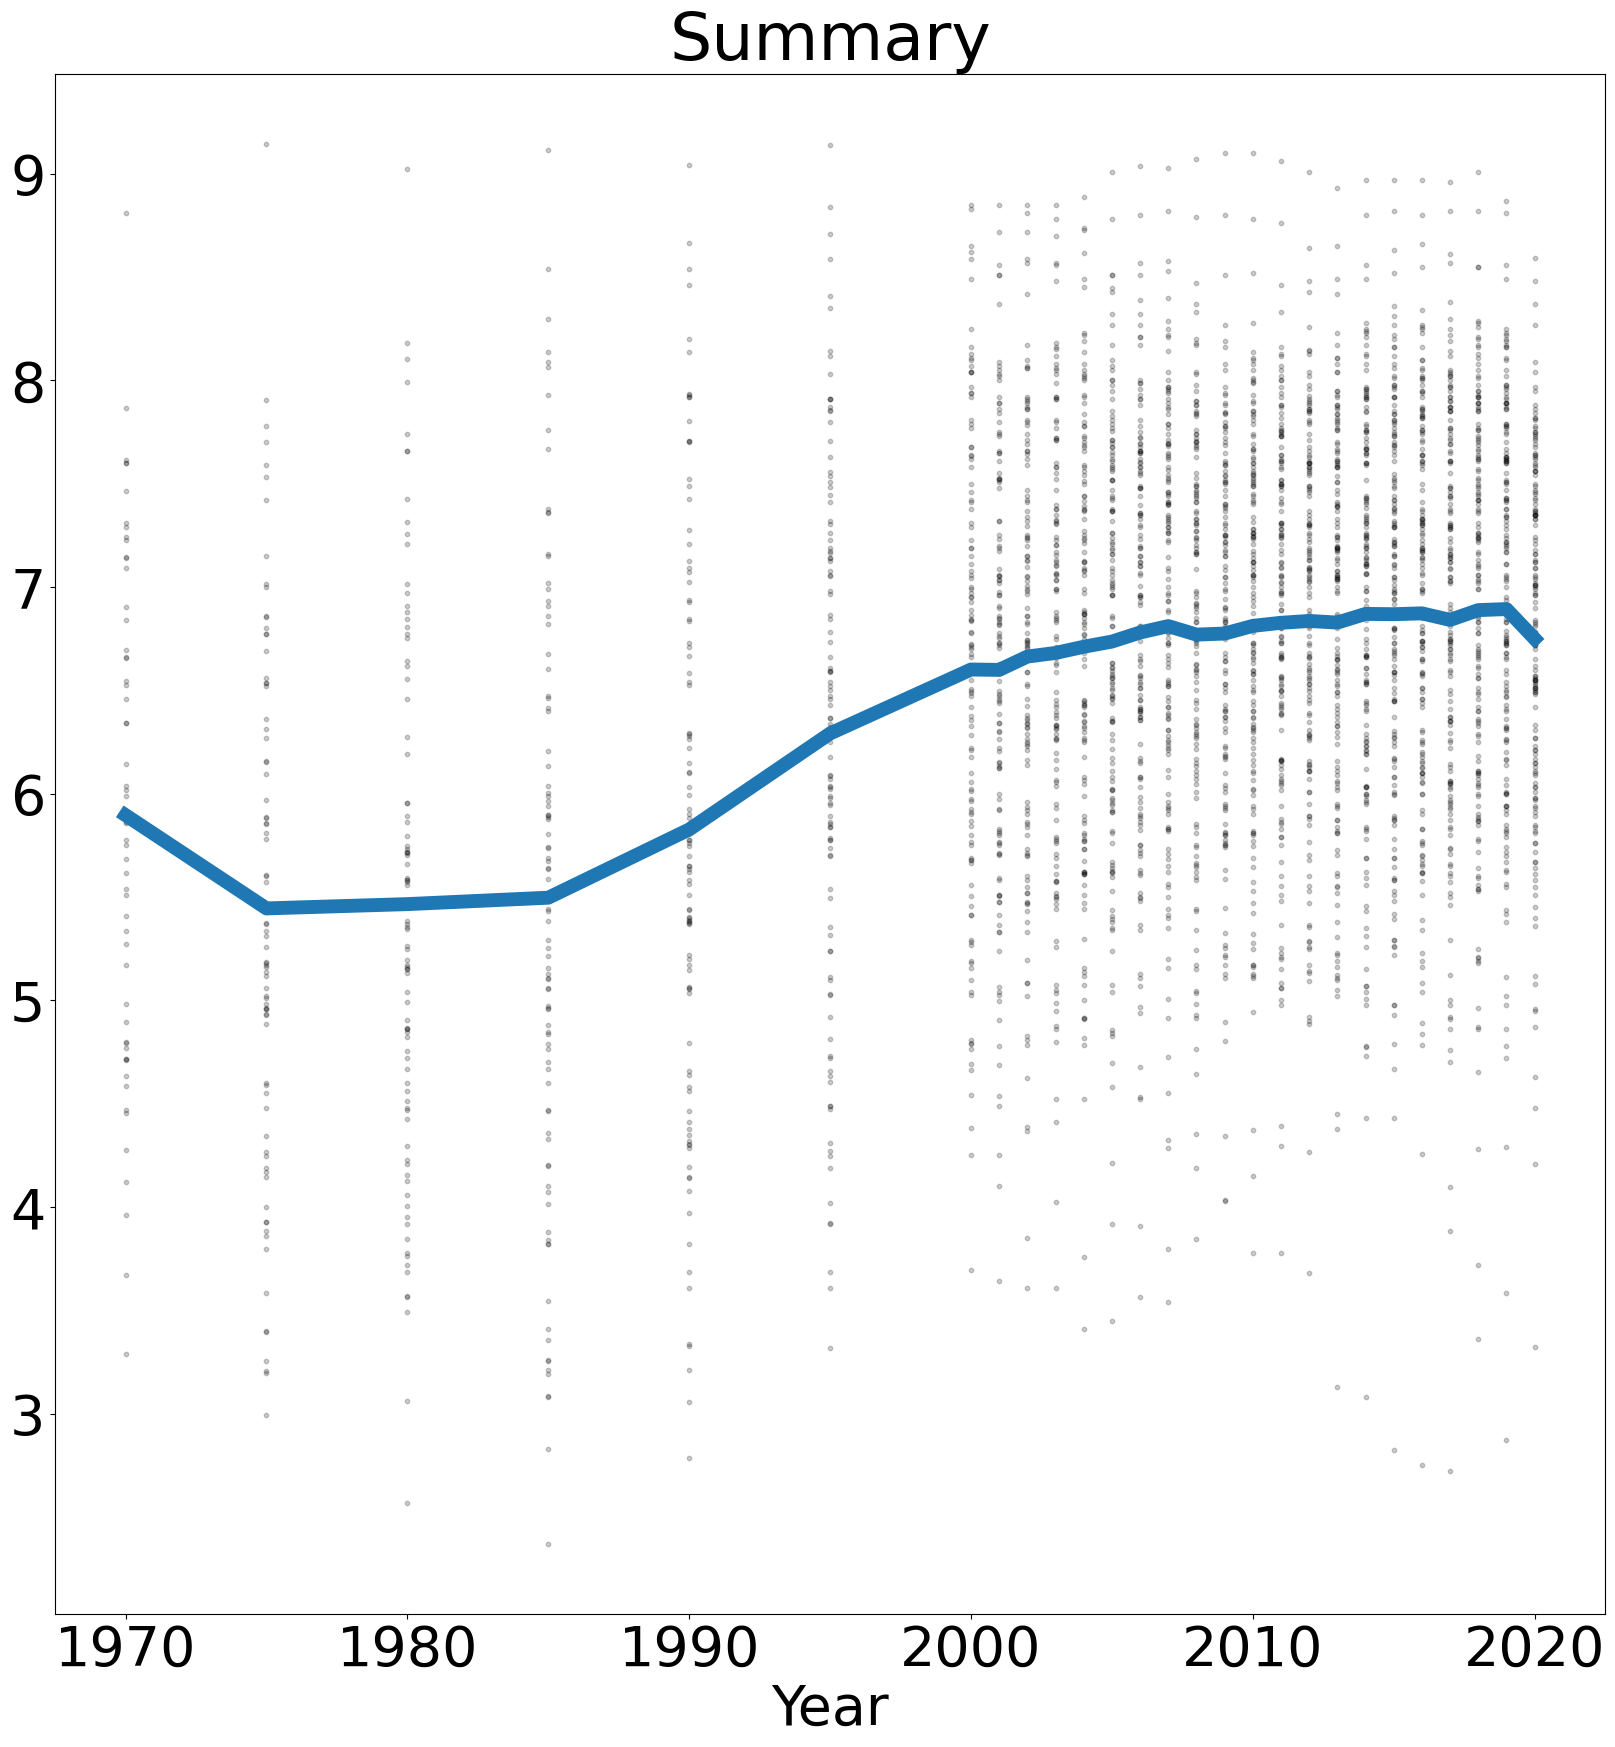

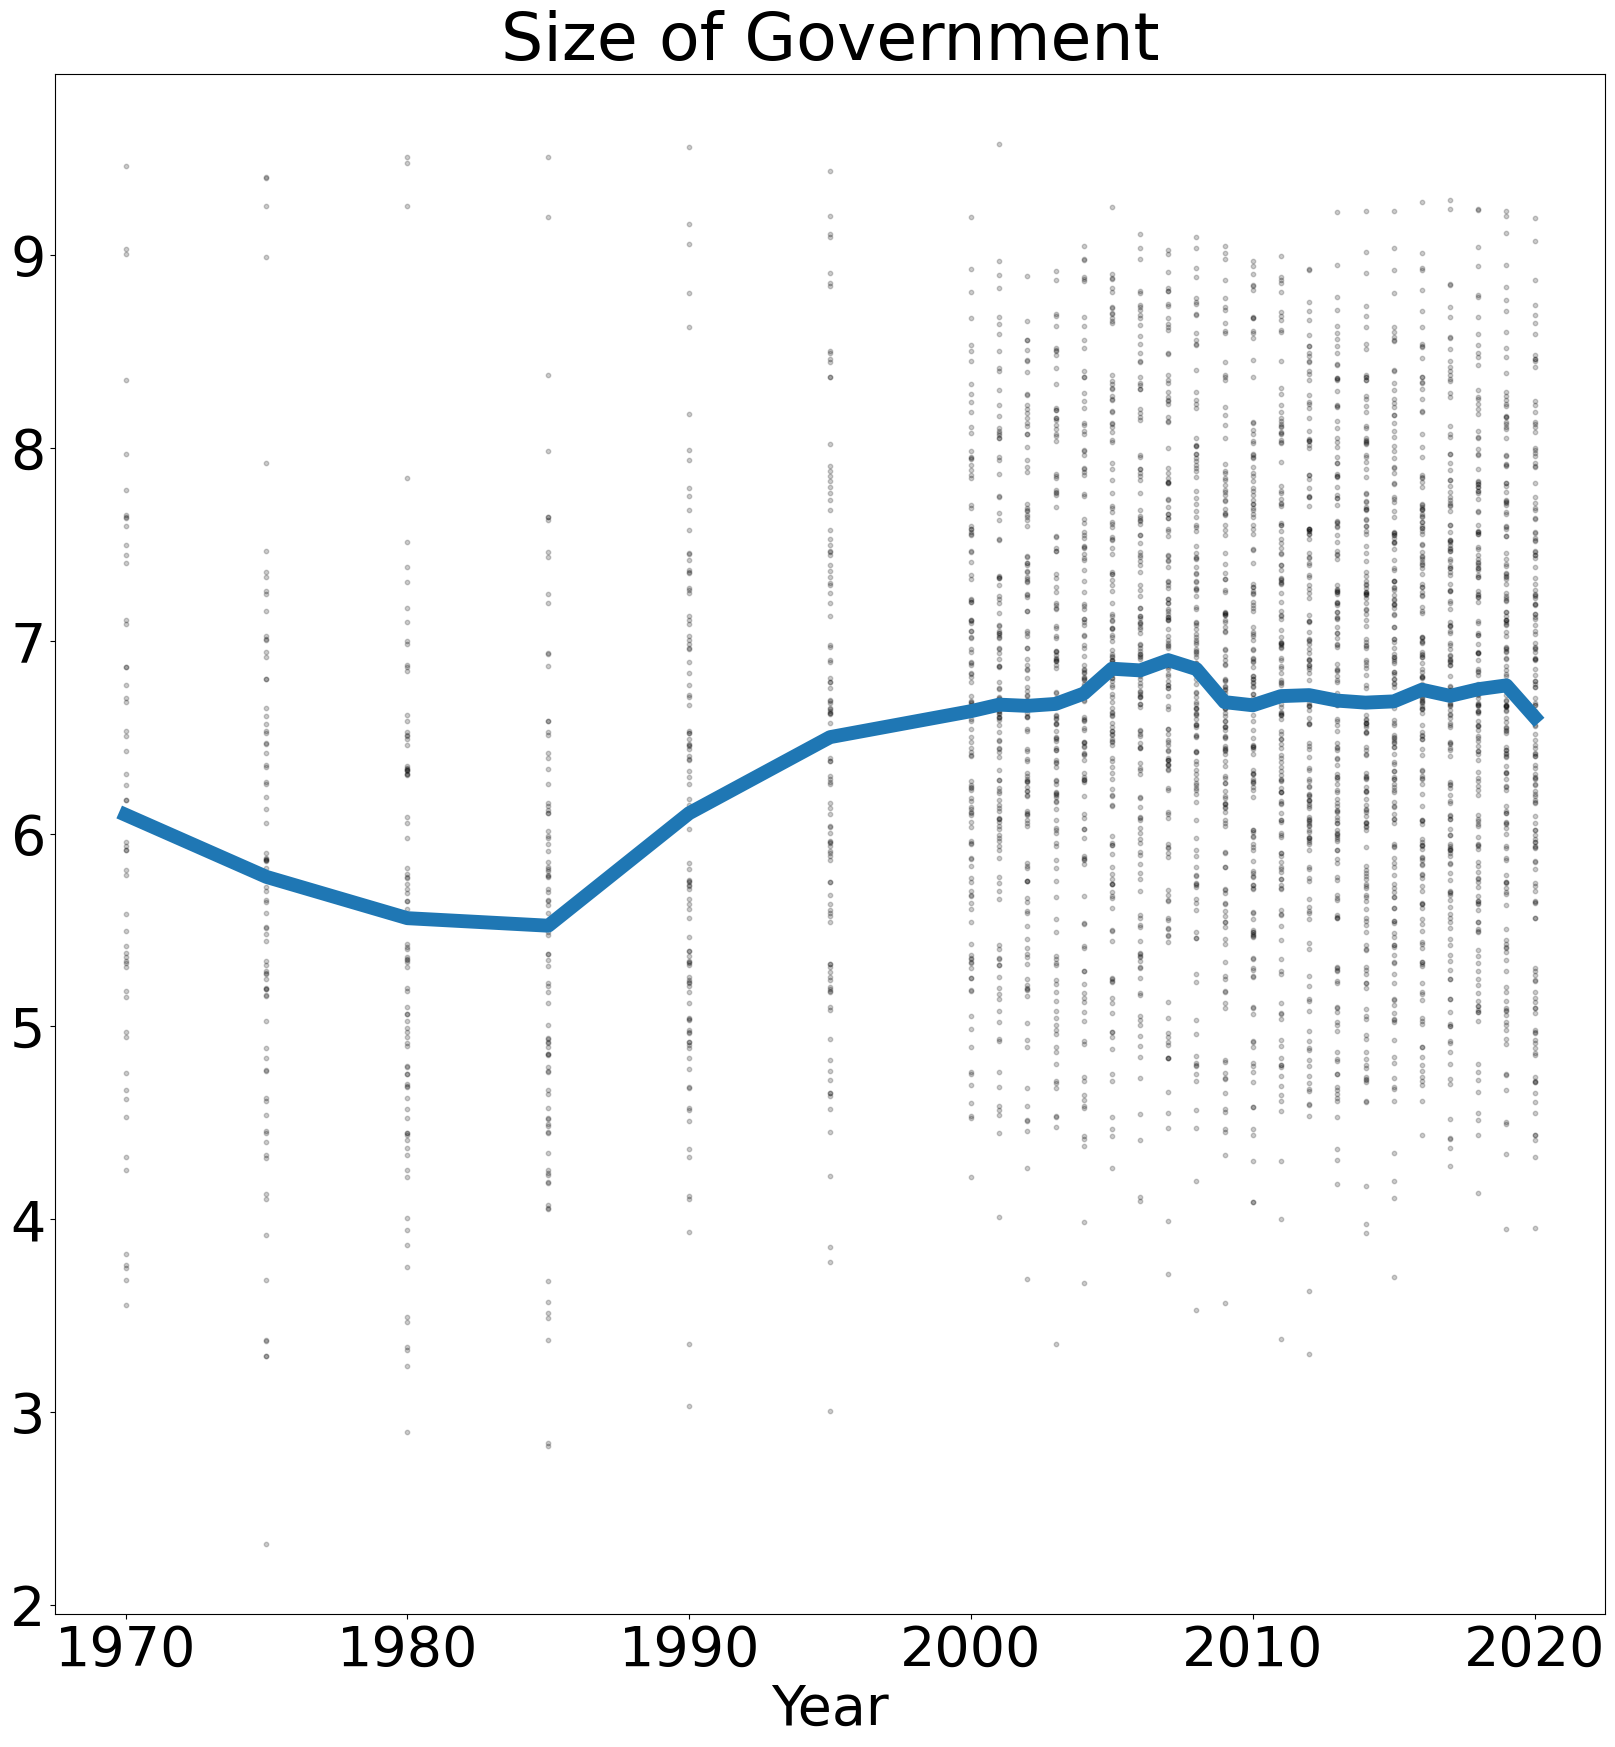

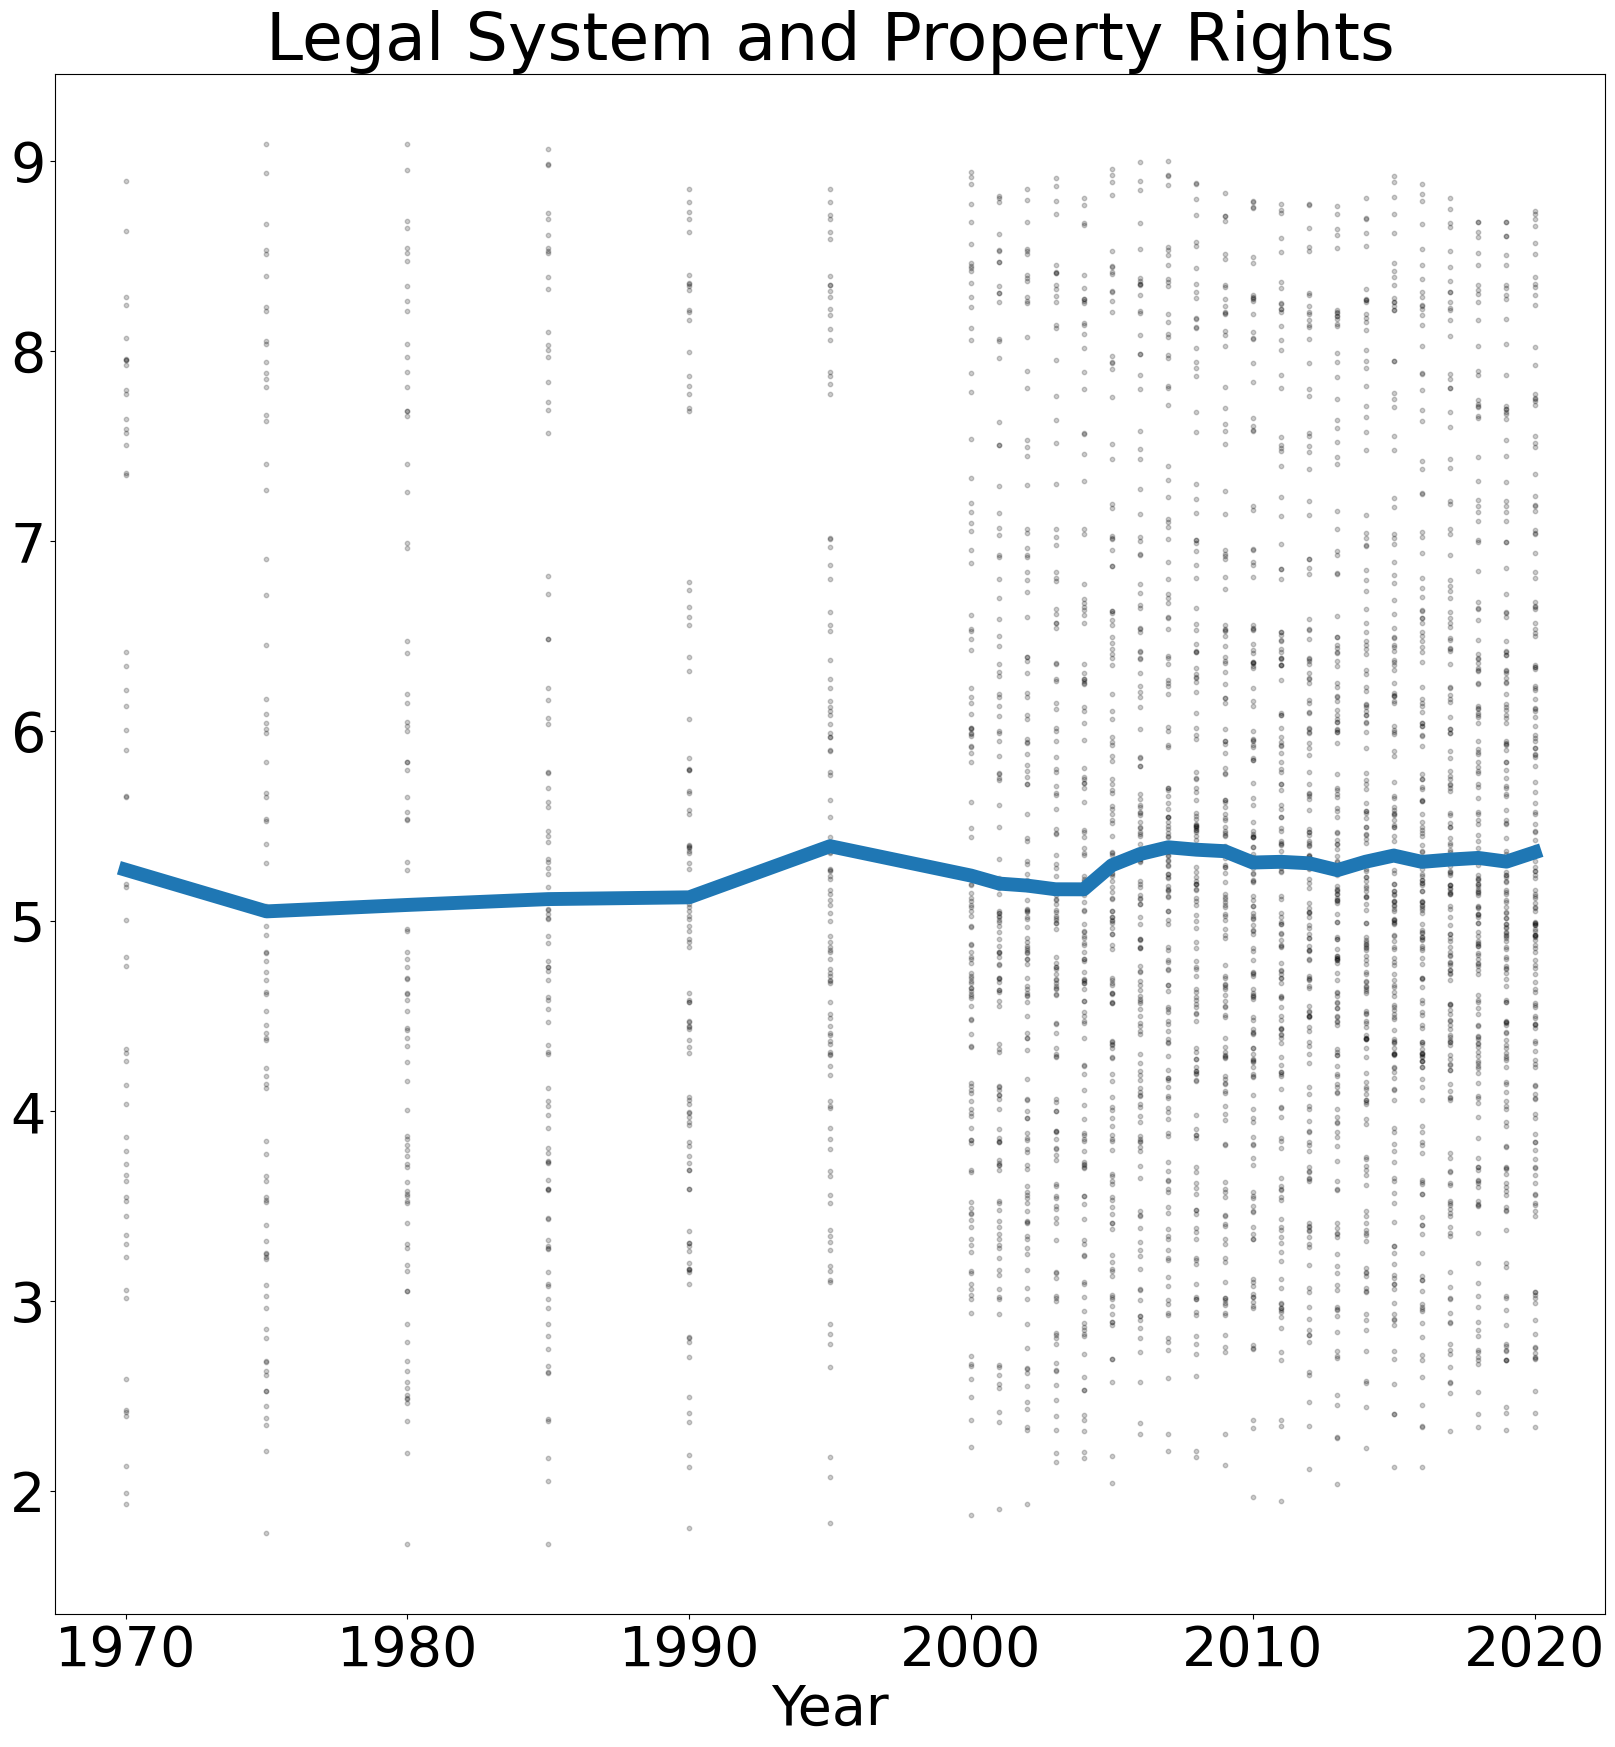

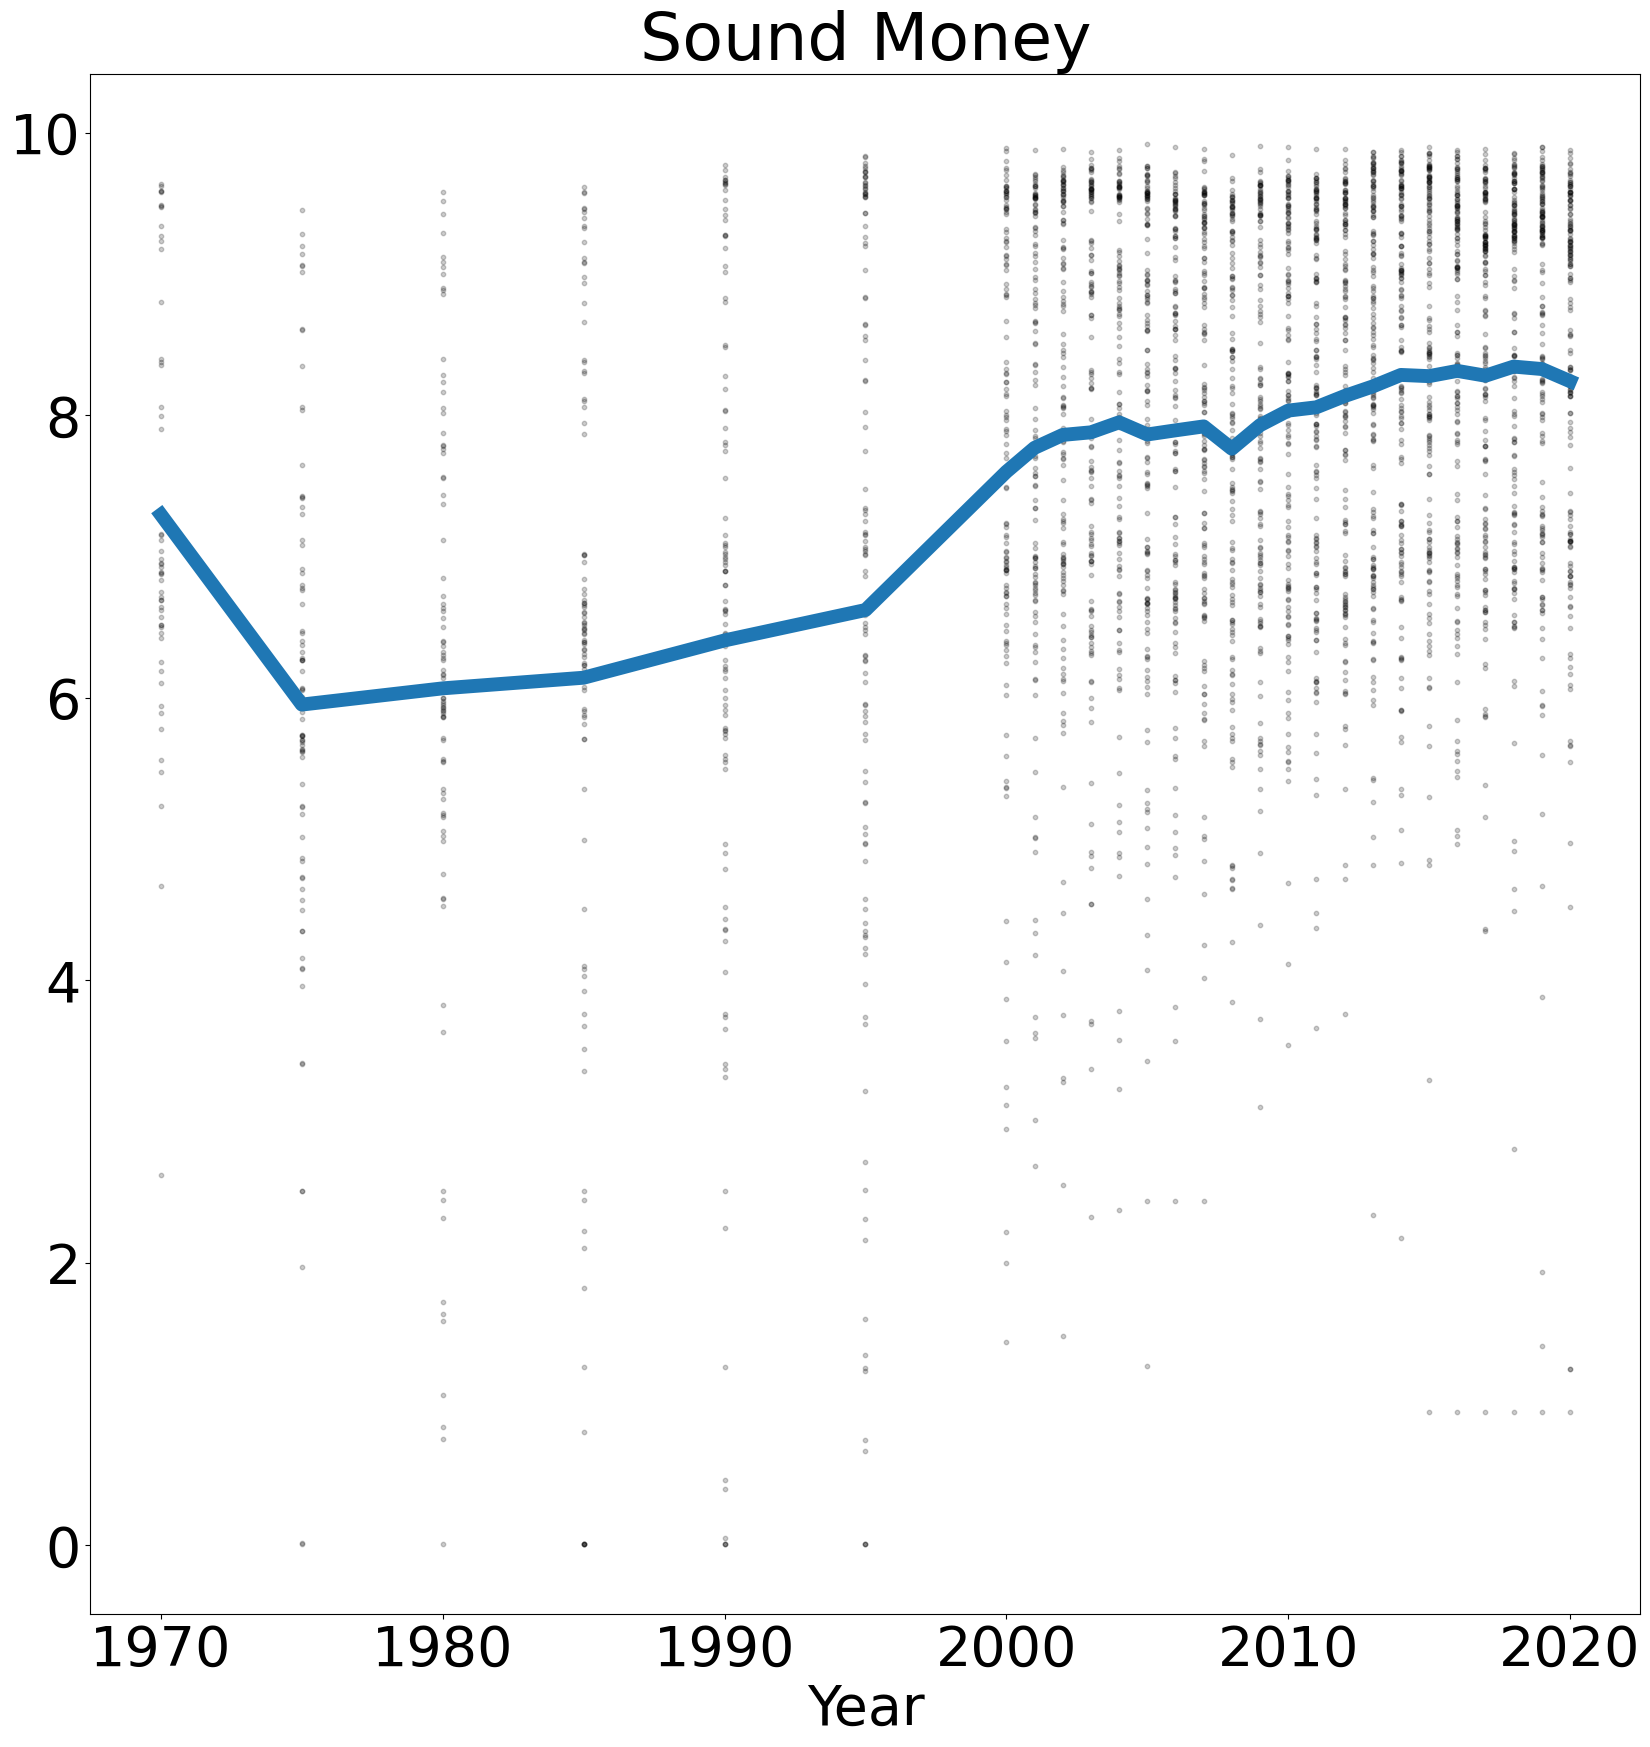

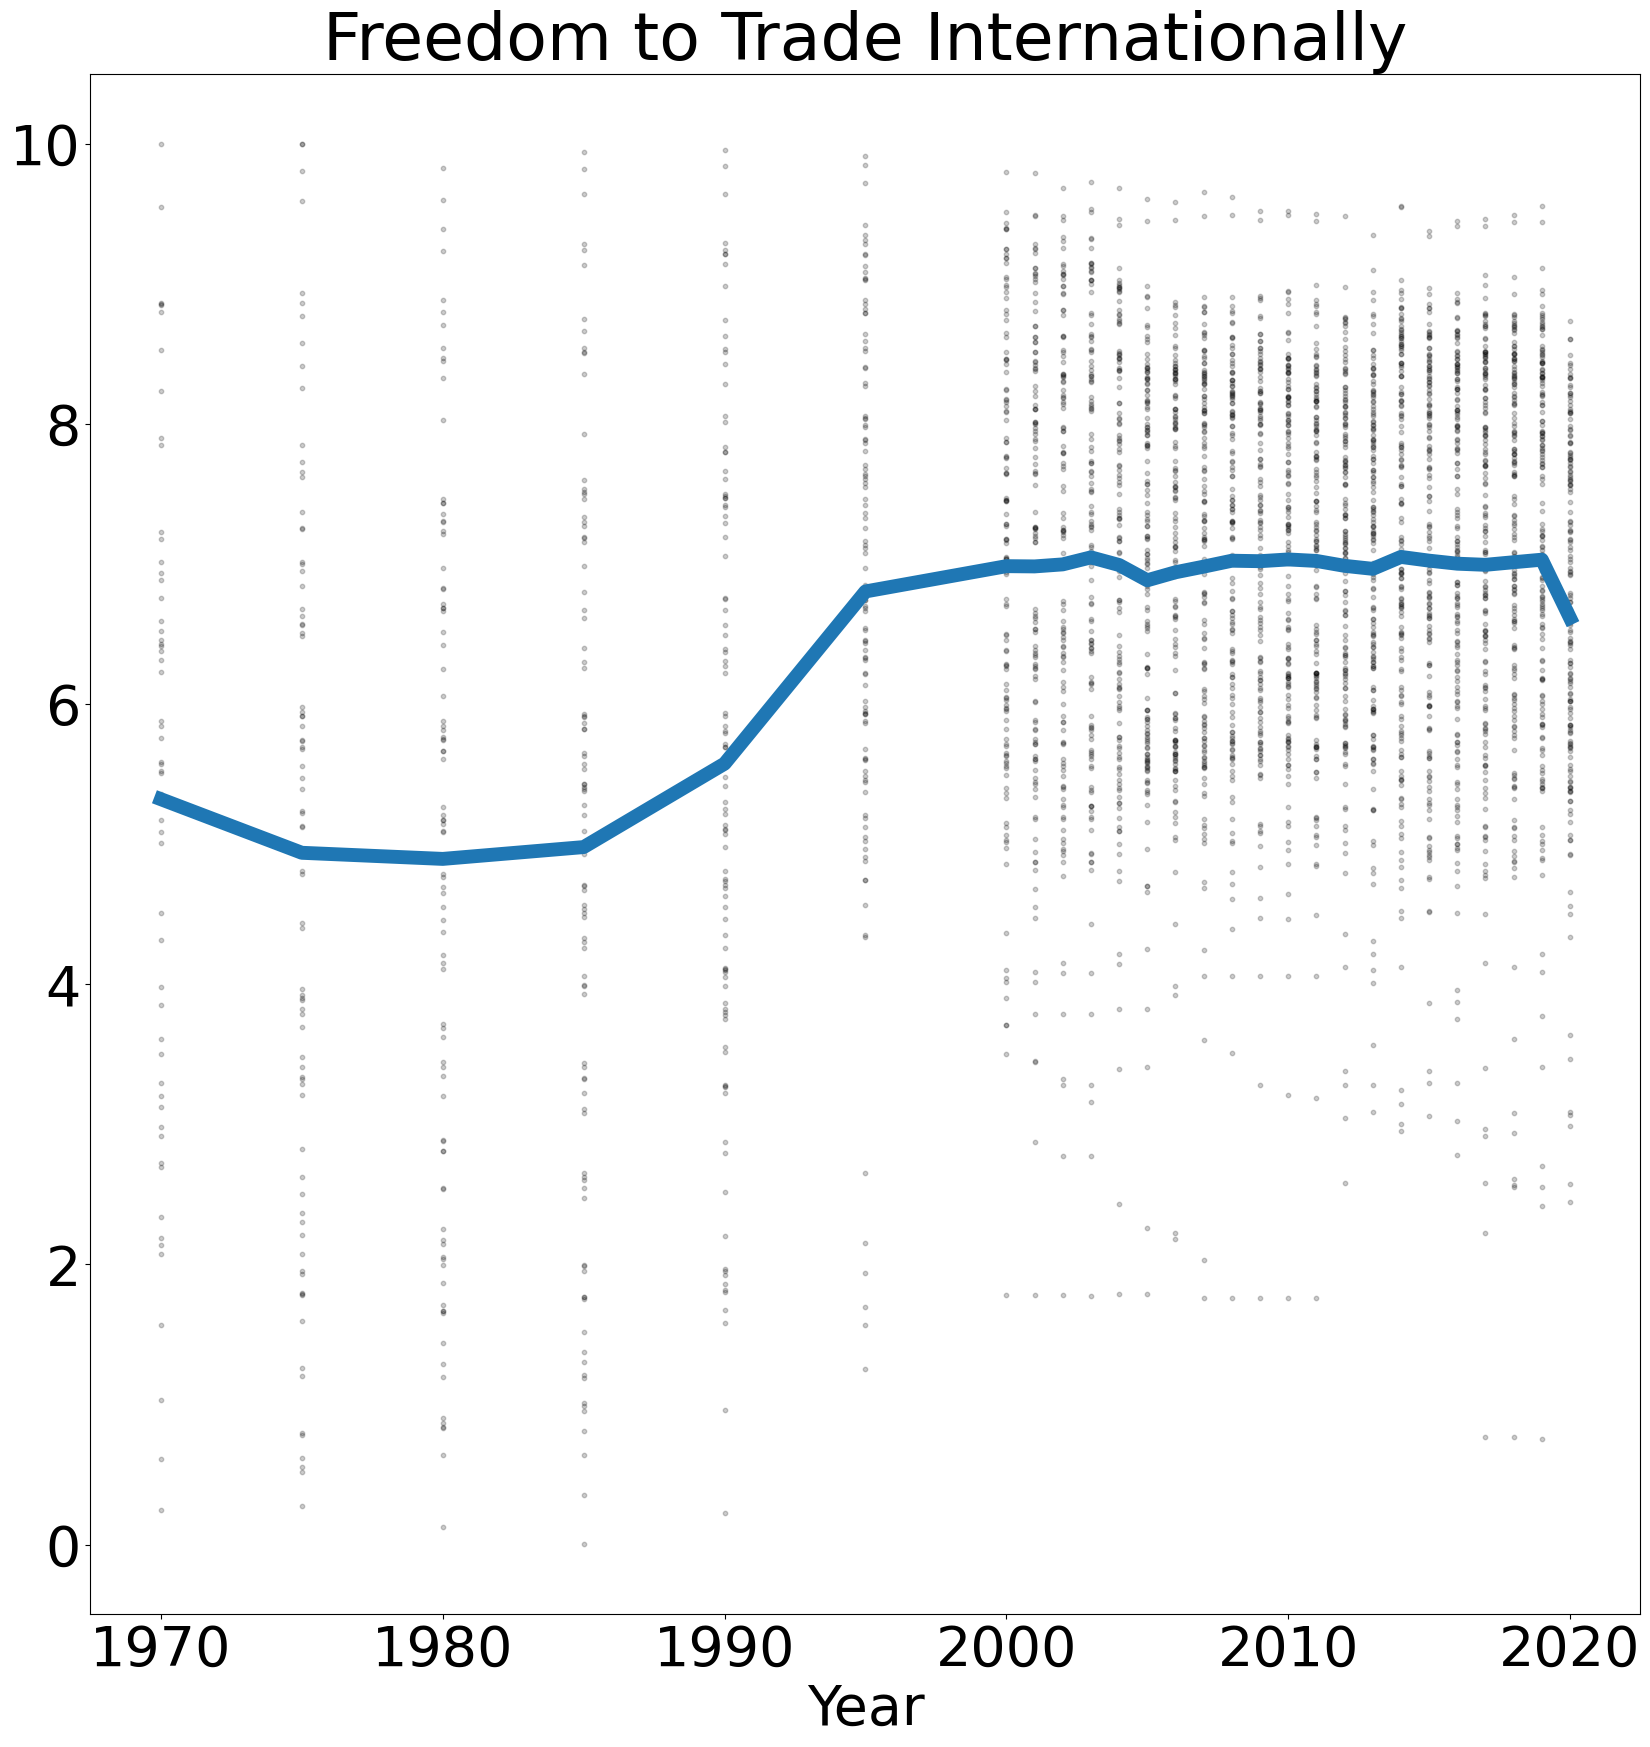

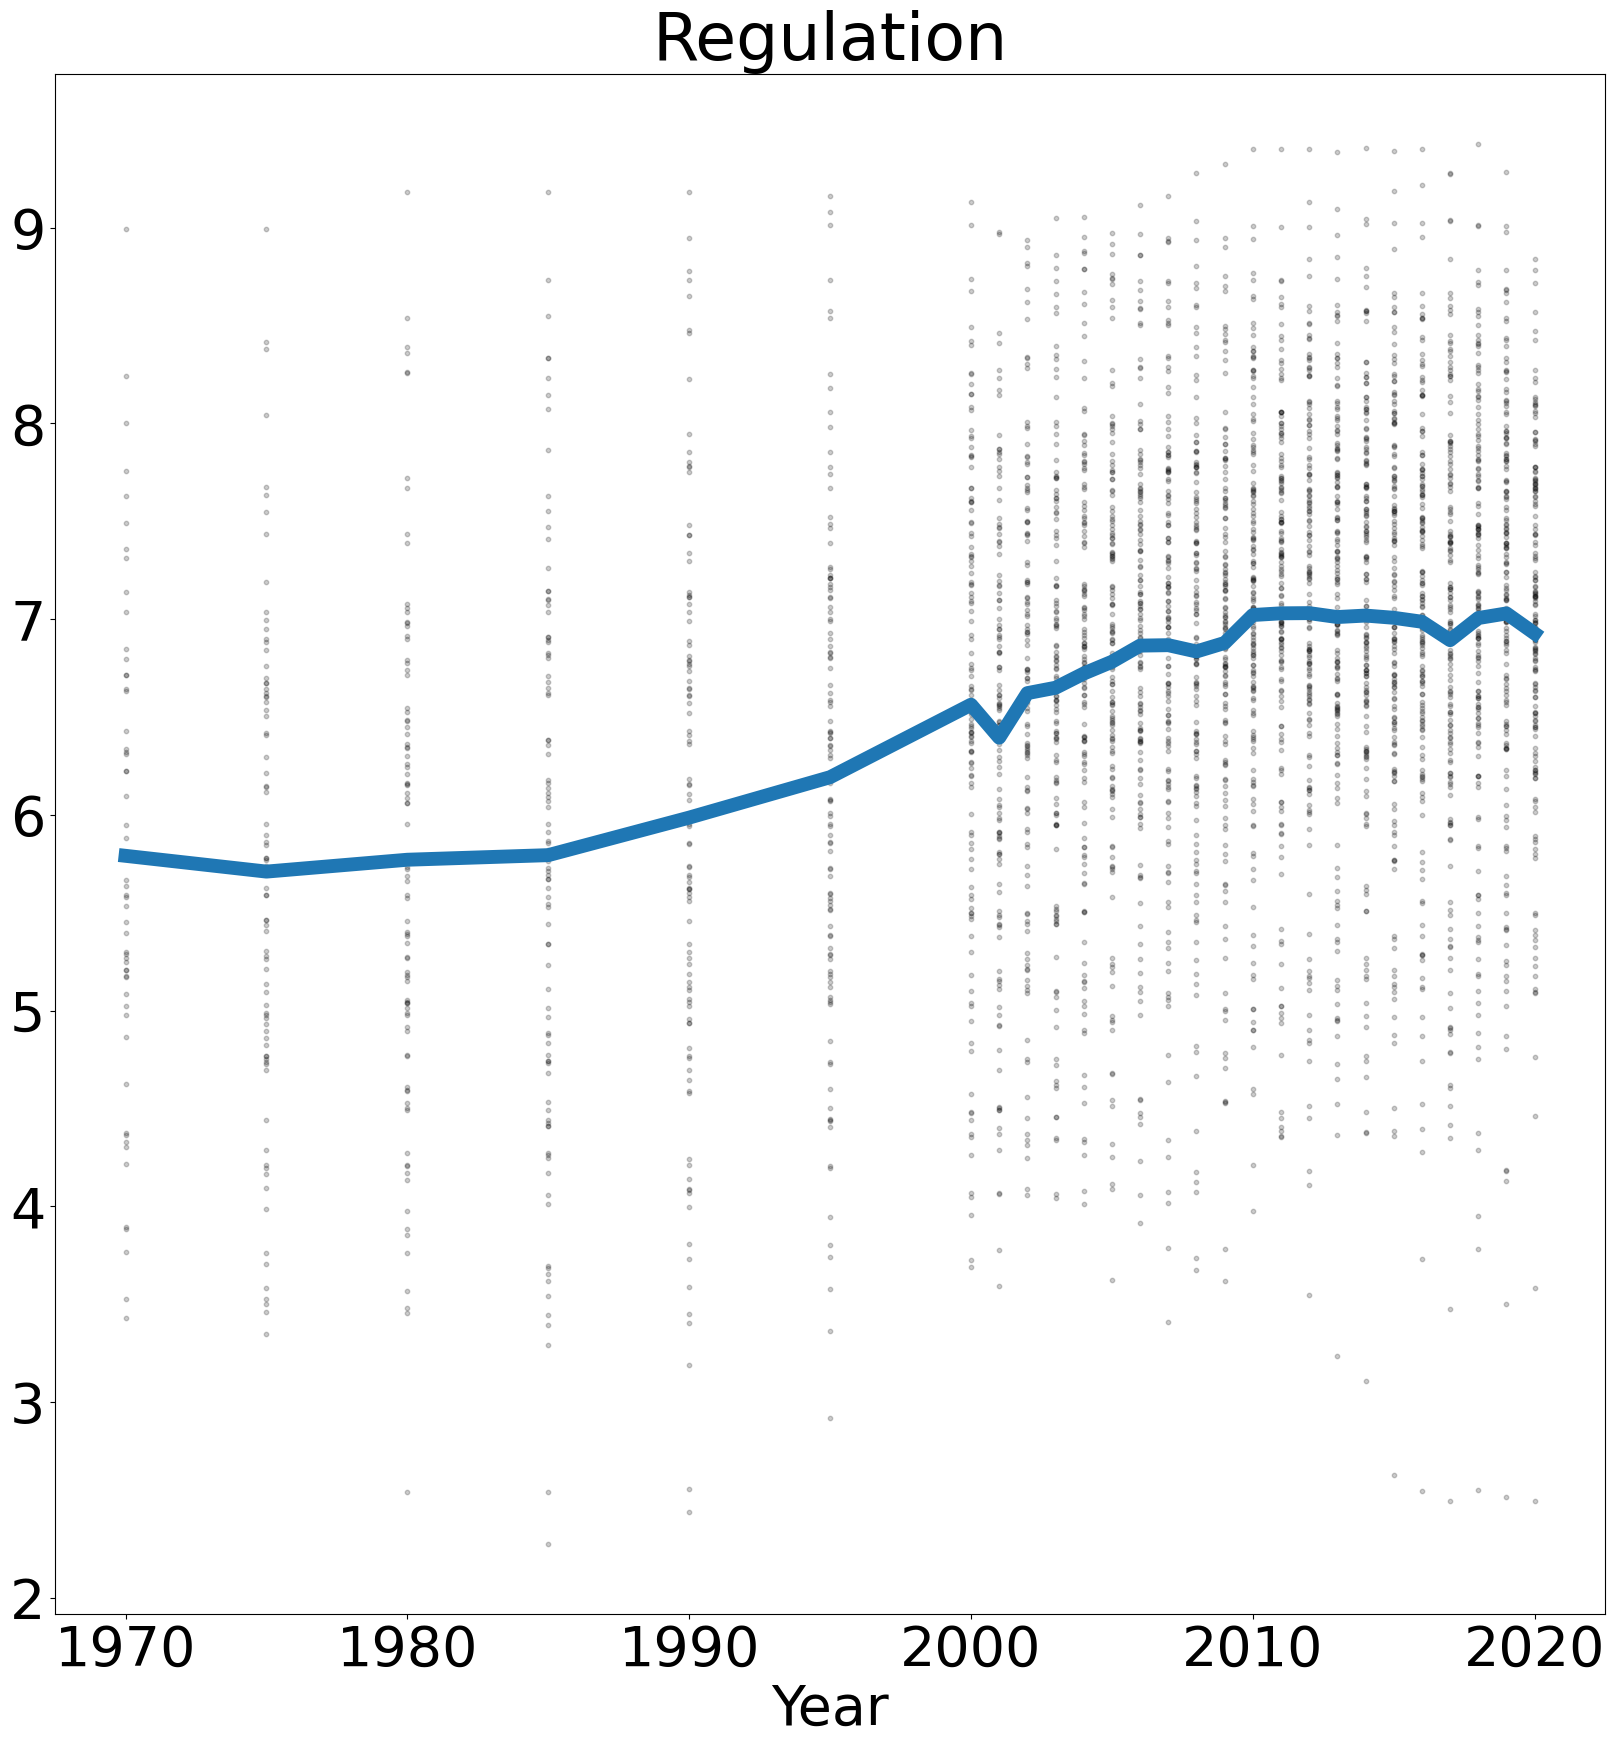

In [50]:
plt.rcParams.update({"font.size" : 40})
mean_data = data.groupby("Year").mean()
for key, val in data.items():
    fig, ax = plt.subplots(figsize = (20, 20))  
    time = val.index.get_level_values("Year")
    ax.scatter(time, val,  alpha = .2, color = "k", s = 10)
    mean_data[key].plot(ax = ax, linewidth = 10, color = "C0")
    ax.set_title(key)
    plt.show()
    pp.savefig(fig, bbox_inches="tight")

    plt.close()

### Correlation Heatmap

Next, we will create a heatmap that shows represents the correlation matrix. This is a relatively straightforward task since we have already organized the data is it will appear in this heatmap. We create another figure using plt.subplots(). The ax variable is used to call imshow, ax.imshow(df), which is creates the heatmap. The labels, however, are not automatically generated. We create a variable that holds the labels and pass, along with an empty list of the same length to plt.xticks() and plt.yticks(). Passing the title “Correlation” to plt.title() generates a title at the top of the plot.

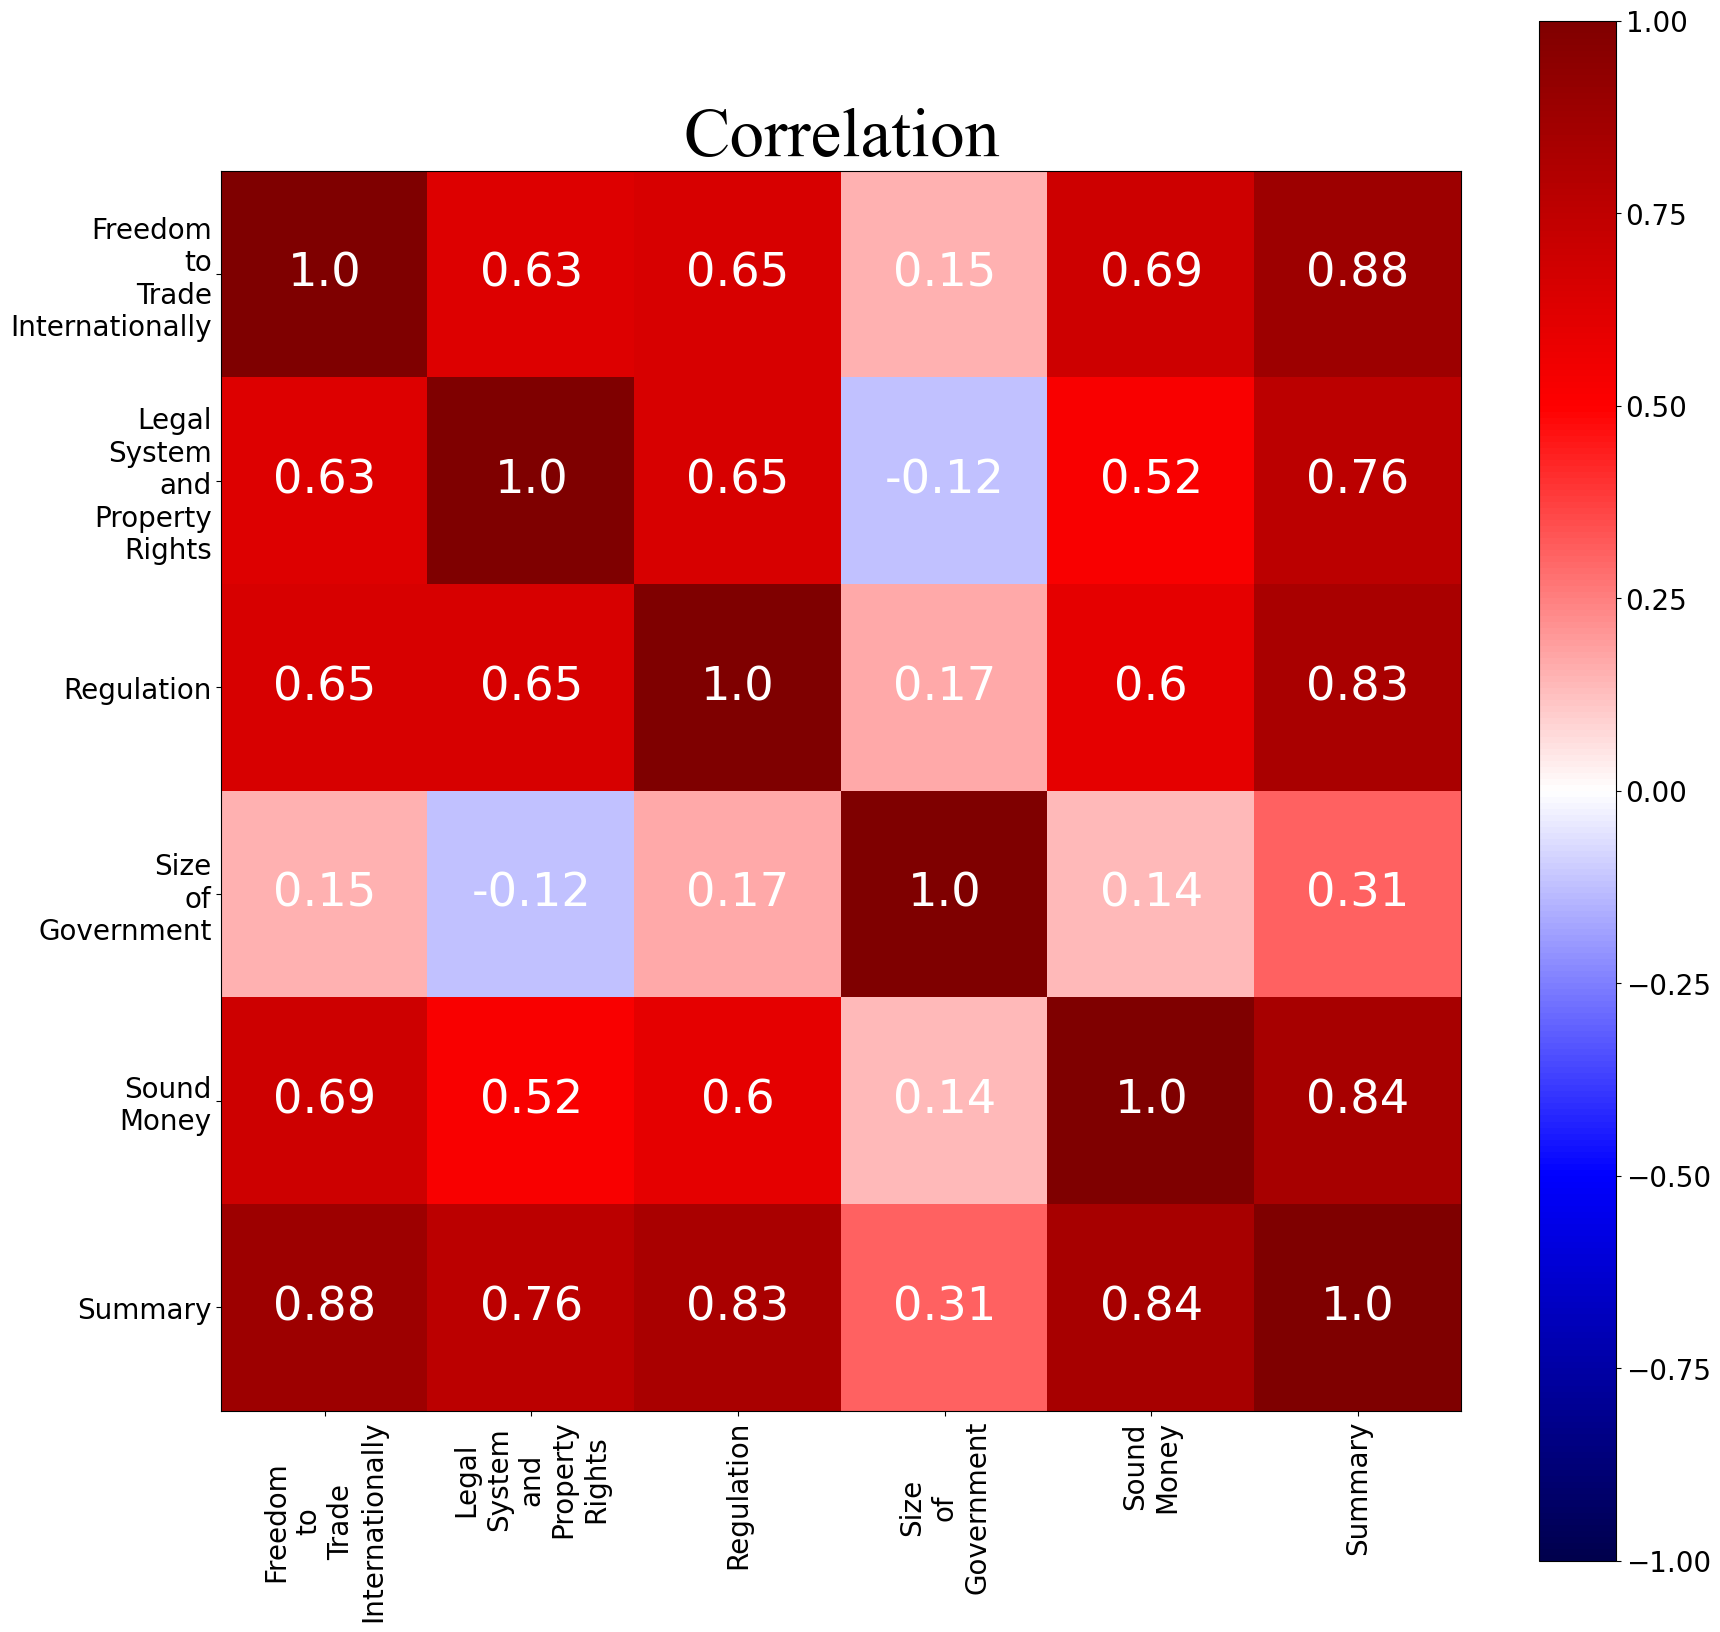

In [51]:
#econFreedomVisualizations.py
import numpy as np
# . . .
def corr_matrix_heatmap(data, pp):  
    #Create a figure to visualize a corr matrix  
    fig, ax = plt.subplots(figsize=(20,20))  
    # use ax.imshow() to create a heatmap of correlation values  
    # seismic mapping shows negative values as blue and positive values as red  
    im = ax.imshow(data, norm = plt.cm.colors.Normalize(-1,1), cmap = "seismic")  
    # create a list of labels, stacking each word in a label by replacing " "  
    # with "\n"  
    labels = data.keys()  
    num_vars = len(labels)  
    tick_labels = [lab.replace(" ", "\n") for lab in labels]  
    # adjust font size according to the number of variables visualized  
    tick_font_size = 120 / num_vars  
    val_font_size = 200 / num_vars  
    plt.rcParams.update({'font.size': tick_font_size}) 
    # prepare space for label of each column  
    x_ticks = np.arange(num_vars)  
    # select labels and rotate them 90 degrees so that they are vertical  
    plt.xticks(x_ticks, tick_labels, fontsize = tick_font_size, rotation = 90)  
    # prepare space for label of each row  
    y_ticks = np.arange(len(labels))  
    # select labels  
    plt.yticks(y_ticks, tick_labels, fontsize = tick_font_size)  
    # show values in each tile of the heatmap  
    for i in range(len(labels)):  
        for j in range(len(labels)):  
            text = ax.text(i, j, str(round(data.values[i][j],2)),  
                           fontsize= val_font_size, ha="center",   
                           va="center", color = "w")  
    #Create title with Times New Roman Font  
    title_font = {"fontname":"Times New Roman"}  
    plt.title("Correlation", fontsize = 50, **title_font)  
    #Call scale to show value of colors 
    cbar = fig.colorbar(im)
    plt.show()
    pp.savefig(fig, bbox_inches="tight")
    plt.close()

#. . . 
# . . .
corr_data = pd.read_csv("econFreedomCorrMatrix.csv", index_col = [0])
corr_matrix_heatmap(corr_data, pp)

The resulting heatmap provides a powerful presentation of the data. Both the actual value of correlation and the color are shown in the same tile, thereby reinforcing the information conveyed to the viewer. It is worthwshile to spend time with a visualization, imagining what changes or additions can be made in order to improve clarity for the viewer. Aesthetics might not be everything, but when time a constraint, a well crafted visualizatoin can convey a significant amount of knowledge.

### Scatterplots and Distributions in a Single Figure
Finally, we create a figure that shows scatterplots of a list of selected variables as well as the distribution of each individual variable. Pandas already has a function built in for this. Due to the variance of figure size, we adjust the size of the text and scatterplot according to the dimensions of the figure.


C:\Users\JLCat\AppData\Local\Temp\ipykernel_22008\1280365306.py:11: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared.



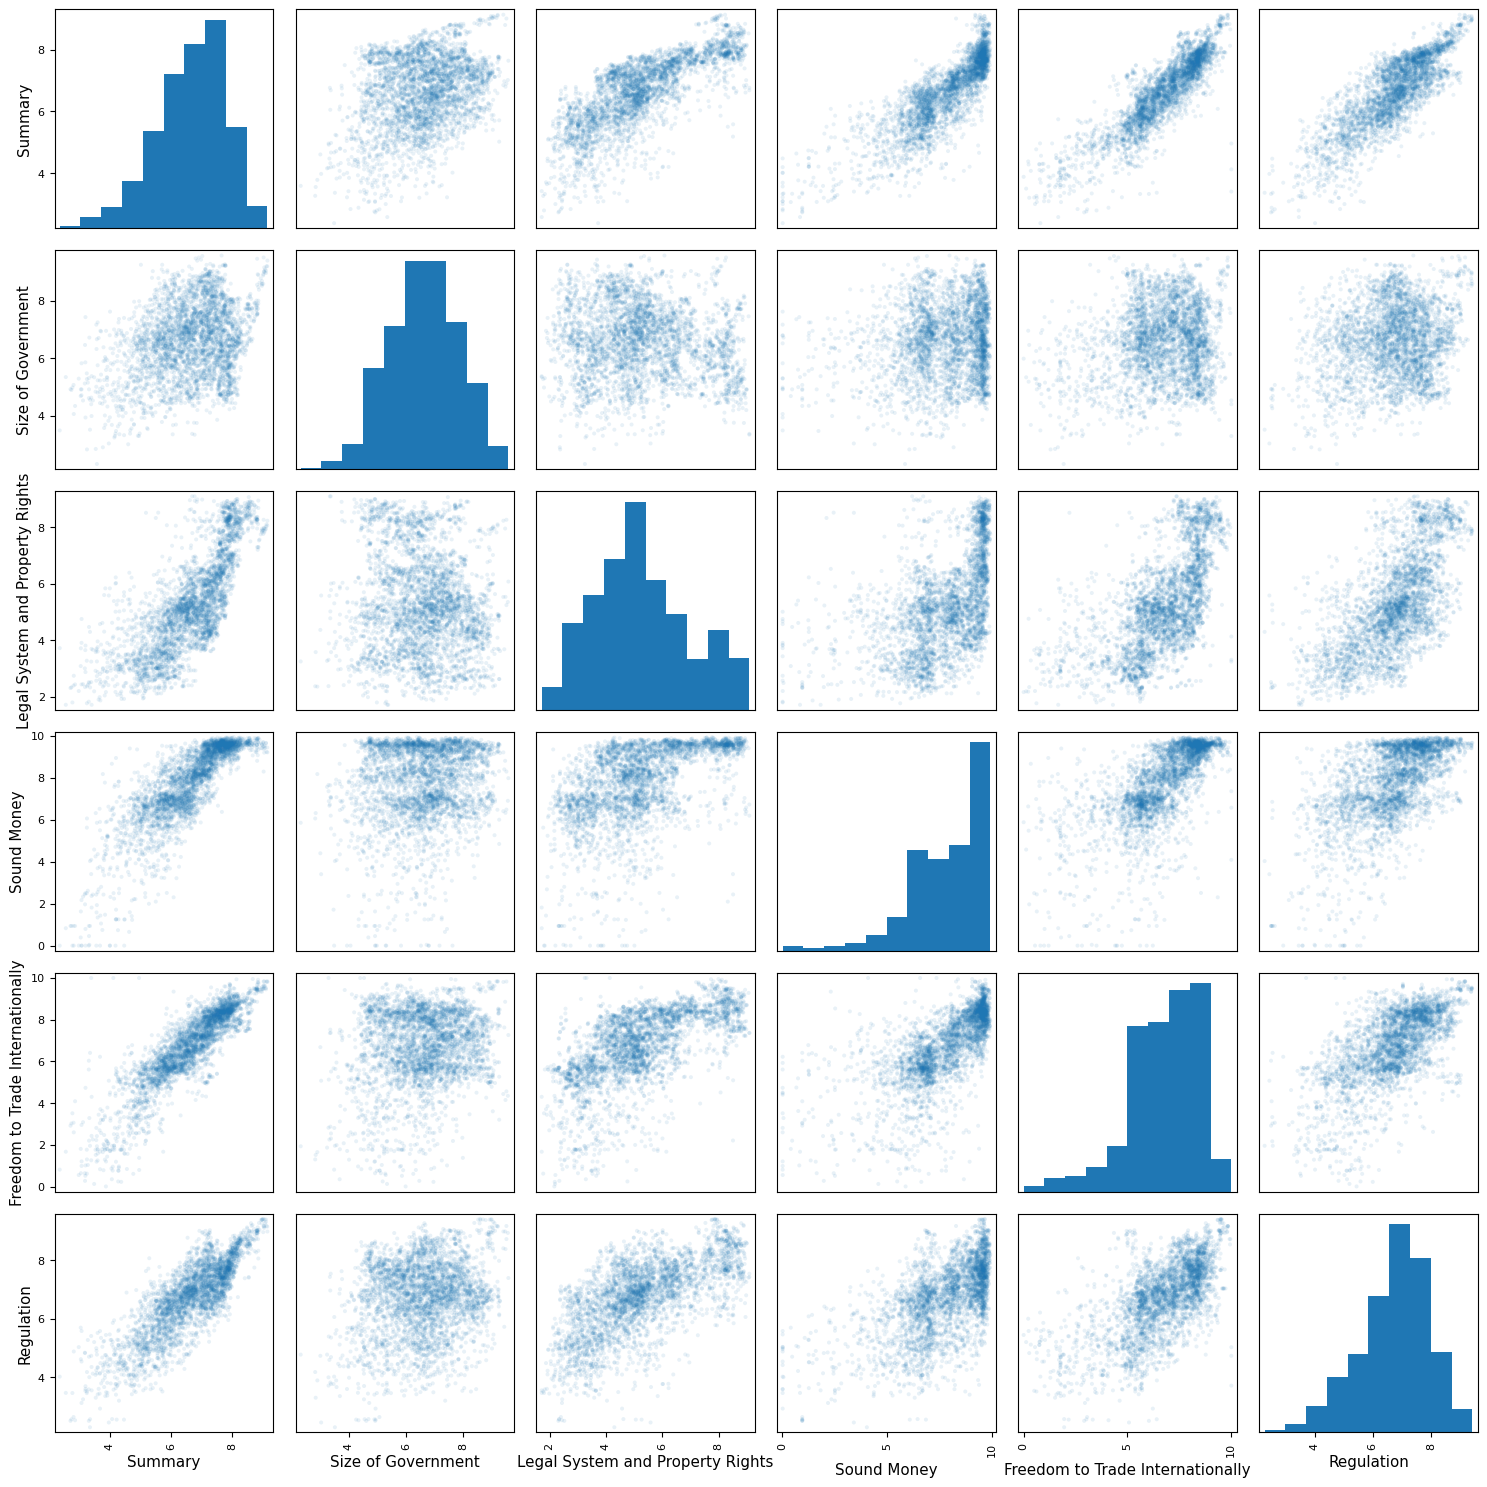

In [52]:
#econFreedomVisualization.py
# . . .
def formatted_scatter_matrix(data, c = "C0", cmap = "viridis", alpha = .1, pp=False):  
    # Create a figure showing scatterplots given in scatter_cats  
    fig_len = 15  
    fig, ax = plt.subplots(figsize = ((fig_len, fig_len)))  
    # Use fig_len to dictate fig_size, adjust size of font, size of dots, etc...  
    num_vars = len(data.keys())  
    fontsize = 65 / num_vars  
    plt.rcParams.update({'font.size': fontsize})  
    pd.plotting.scatter_matrix(data, c = c, alpha = alpha, s = 200 / num_vars, ax=ax)  
    # tight layout improves layout of text and plots in the figure  
    plt.tight_layout()  
    plt.show()  
    if pp != False:
        pp.savefig(fig, bbox_inches = "tight")  
    plt.close()  
formatted_scatter_matrix(data,pp= pp)
pp.close()

### Exercises
1. Create a list of random numbers between 0 and 100 whose length is 1000. (Hint: import random; search "python random" to learn more about the library.)

2. Use the variance function from the textbook to find the variance of this list. Assume that the list represent a population in whole. 

3. Create a 9 more lists of the same length whose elements are random numbers between 0 and 100. Use a nested dictionary to house and identify these lists. Keys for the first layer should be the numbers 1 through 10. Lists should be stored using a second key as follows: dict_name[index]["list"]. Index represents the particular integer key between 1 and 10 as noted above.

4. Find the variance of each list and store it as follows: dict_name[index]["variance"].

5. At the end of chapter 2, we used for loops to find min and max values. Create a min() function and max() function and pass the values from the list in question 1 to each of these to determine the min and max values in that list.

6. Explain why it might be advantageous to create a function instead of building all commands from scratch as you create a script.

